In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact 

# Define the directory containing the sample directories
base_dir = "/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/cellranger_outs/"
filename = 'cellbender_doublet_detection_filtered_feature_bc_matrix.h5'


## Filter, normalize, and integrate

In [2]:
def filter_cells(dat, name, verbose=True):
    n_initial = dat.shape[0]

    # Calculate mitochondrial gene percentage
    dat.var['mt'] = dat.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(dat, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    # 1. Filter cells with mitochondrial gene percentage < 10%
    dat = dat[dat.obs['pct_counts_mt'] < 10, :].copy()

    # 2. Filter cells with 100–2500 detected genes
    dat = dat[(dat.obs['n_genes_by_counts'] >= 100) & (dat.obs['n_genes_by_counts'] <= 4300)].copy() # 

    # 3. Keep genes expressed in at least 3 cells
    sc.pp.filter_genes(dat, min_cells=3)

    # 4. Remove platelets (PF4, UMI > 0)
    if 'PF4' in dat.var_names:
        dat = dat[dat[:, 'PF4'].X.toarray().flatten() == 0].copy()

    # 5. Remove red blood cells (HBB, UMI > 1)
    if 'HBB' in dat.var_names:
        dat = dat[~(dat[:, 'HBB'].X.toarray().flatten() > 1)].copy()

    # 6. Remove doublets
    dat = dat[~(dat.obs['doublet'] == 1)].copy()

    n_removed = n_initial - dat.shape[0]
    if verbose:
        print(f'{name}: Filtered out {n_removed} cells')
    return dat


In [3]:
samples = ['CRPC_S01','CRPC_S02','CRPC_S03','CRPC_S04','CRPC_S05','CRPC_S06',
'HSPC_S07','HSPC_S08','HSPC_S09','HSPC_S10','HSPC_S11','HSPC_S12','HSPC_S13',
'HSPC_S14','HSPC_S15','HSPC_S16','HSPC_S17','HSPC_S18','HSPC_S19','HSPC_S20',
'HSPC_S21','HSPC_S22','HSPC_S23','HSPC_S24','HSPC_S25','HSPC_S26','HSPC_S27',
'HSPC_S28','HSPC_S29','HSPC_S30','HSPC_S31',
'PC_S32','PC_S33','PC_S34','PC_S35','PC_S36','PC_S37','PC_S38','PC_S39',
'PC_S40','PC_S41','PC_S42','PC_S43','PC_S44']
samples_dict = {}
for s in samples:
    adata = sc.read_h5ad(f'{base_dir}{s}/outs/{filename}')
    adata.obs['sample'] = s
    adata.obs['type'] = s.split('_')[0]
    #adata = filter_cells(adata,s,verbose=False)
    samples_dict[s] = adata.copy()

In [4]:
adata_concat = ad.concat(samples_dict,join='outer')
adata_concat = filter_cells(adata_concat,'all',verbose=False)
adata_concat

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 147180 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [5]:
n_cells_list = []
for s in samples_dict:
    n_cells = samples_dict[s].shape[0]
    n_cells_list.append(n_cells)
    print(f'{s}: {n_cells} cells')
print()
print('Total cells: ' + str(np.sum(n_cells_list)))

CRPC_S01: 2084 cells
CRPC_S02: 16791 cells
CRPC_S03: 3559 cells
CRPC_S04: 5483 cells
CRPC_S05: 19516 cells
CRPC_S06: 13044 cells
HSPC_S07: 17564 cells
HSPC_S08: 24673 cells
HSPC_S09: 5989 cells
HSPC_S10: 15613 cells
HSPC_S11: 15991 cells
HSPC_S12: 9414 cells
HSPC_S13: 8605 cells
HSPC_S14: 9368 cells
HSPC_S15: 12991 cells
HSPC_S16: 13019 cells
HSPC_S17: 9502 cells
HSPC_S18: 7594 cells
HSPC_S19: 9961 cells
HSPC_S20: 12405 cells
HSPC_S21: 15686 cells
HSPC_S22: 24850 cells
HSPC_S23: 23650 cells
HSPC_S24: 11360 cells
HSPC_S25: 8876 cells
HSPC_S26: 10355 cells
HSPC_S27: 12960 cells
HSPC_S28: 11845 cells
HSPC_S29: 13781 cells
HSPC_S30: 9709 cells
HSPC_S31: 13284 cells
PC_S32: 25000 cells
PC_S33: 8800 cells
PC_S34: 6295 cells
PC_S35: 19700 cells
PC_S36: 16295 cells
PC_S37: 18685 cells
PC_S38: 20480 cells
PC_S39: 16639 cells
PC_S40: 25000 cells
PC_S41: 6727 cells
PC_S42: 24997 cells
PC_S43: 15241 cells
PC_S44: 24921 cells

Total cells: 618302


In [ ]:
# 131 417 missing PC_S32 & PC_S42 that were processed with Cellbender --expected-cells = 5000 due to failure
# 133 131 all included
# 136 746 when performing the filtering on the joint matrix
# 147 174 in the original


In [6]:

adata_concat.raw = adata_concat.copy()

sc.pp.normalize_total(adata_concat, target_sum=1e4)

sc.pp.log1p(adata_concat)

# Save the log1p
adata_concat.layers['log1p'] = adata_concat.X.copy()

# Calculate HVGs
sc.pp.highly_variable_genes(adata_concat)

print('Performing regression...')
# Regress out total counts and mitochondrial percentage
sc.pp.regress_out(adata_concat, ['total_counts', 'pct_counts_mt'])

print('Scaling...')
# Scale the data
sc.pp.scale(adata_concat)

print('Calculating PCA...')
# Perform PCA
sc.tl.pca(adata_concat, n_comps=50)

print('Running Harmony integration...')
sc.external.pp.harmony_integrate(adata_concat, key='sample')

print('Creating neighborhood graph...')
sc.pp.neighbors(adata_concat, use_rep='X_pca_harmony')

print('Clustering...')
# Leiden clustering
sc.tl.leiden(adata_concat, resolution=1.0)

print('Creating UMAP...')
# UMAP visualization
sc.tl.umap(adata_concat)

#adata_concat.write_h5ad('/scratch/svc_td_compbio/users/kiviaho/preprocessed_h5ad/complete_data_preprocessed.h5ad')



Performing regression...
Scaling...
Calculating PCA...
Running Harmony integration...


2025-08-13 11:45:48,267 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-08-13 11:45:59,990 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-08-13 11:46:00,910 - harmonypy - INFO - Iteration 1 of 10
2025-08-13 11:47:08,089 - harmonypy - INFO - Iteration 2 of 10
2025-08-13 11:48:15,089 - harmonypy - INFO - Iteration 3 of 10
2025-08-13 11:49:22,006 - harmonypy - INFO - Iteration 4 of 10
2025-08-13 11:50:29,065 - harmonypy - INFO - Iteration 5 of 10
2025-08-13 11:51:36,607 - harmonypy - INFO - Iteration 6 of 10
2025-08-13 11:52:44,332 - harmonypy - INFO - Iteration 7 of 10
2025-08-13 11:53:51,984 - harmonypy - INFO - Converged after 7 iterations


Creating neighborhood graph...
Clustering...


/tmp/ipykernel_3402310/3024269463.py:33: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_concat, resolution=1.0)


Creating UMAP...


In [8]:
adata_concat.write_h5ad('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/complete_data_preprocessed.h5ad')

## Cluster annotation

In [62]:
adata_concat = sc.read_h5ad('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/complete_data_preprocessed.h5ad')

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


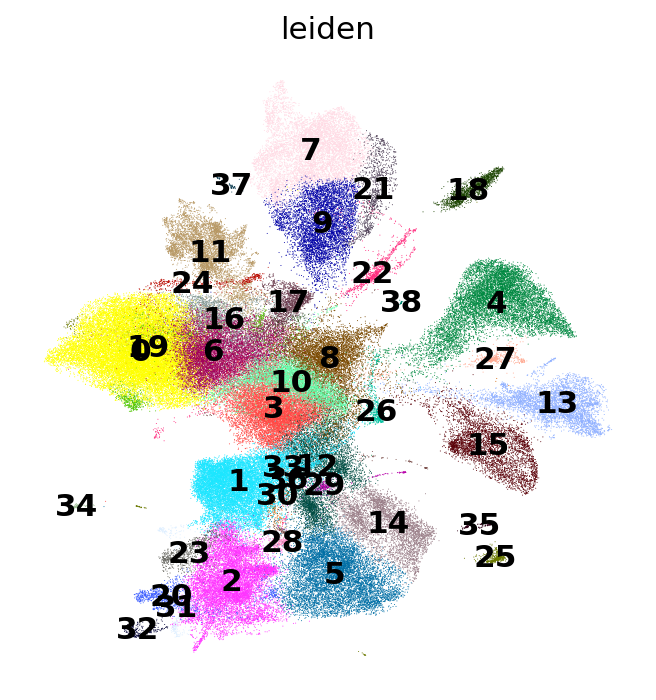

In [63]:
fig, ax= plt.subplots(figsize=(5,5.2))
sc.pl.umap(adata_concat,color='leiden',legend_loc='on data',frameon=False,ax=ax,show=False)
plt.show()

{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

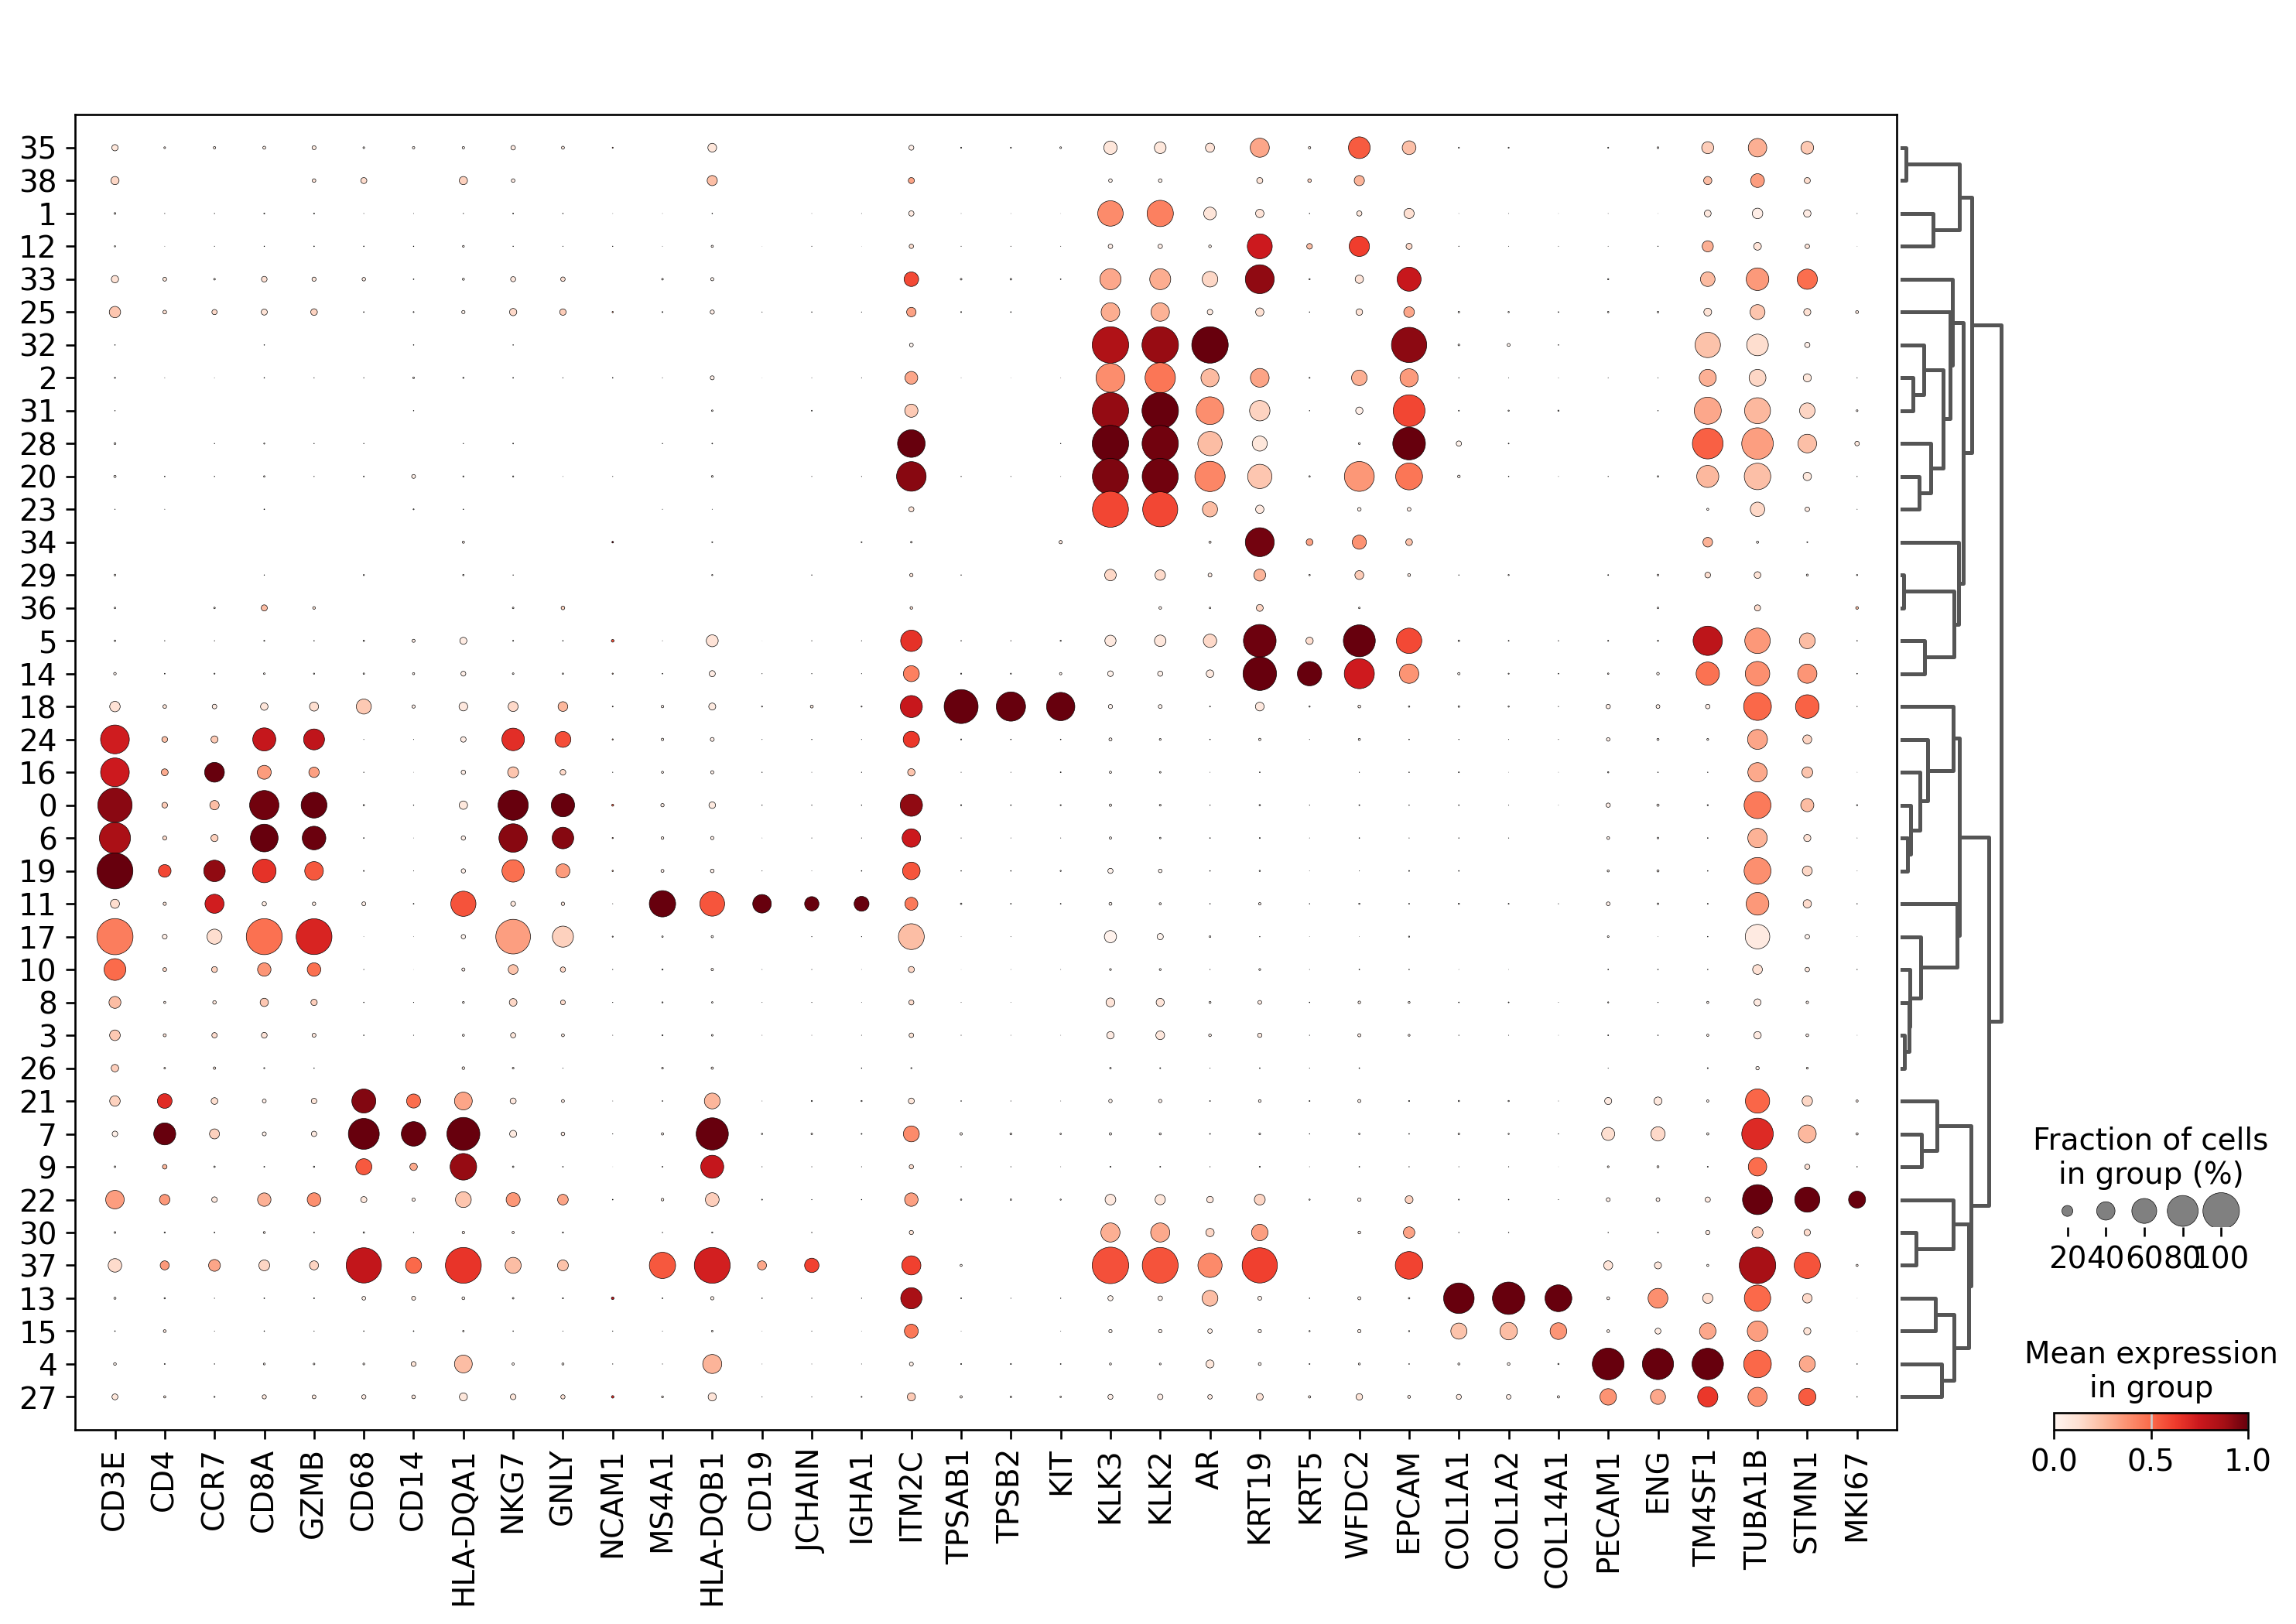

In [64]:
gene_markers = {
    "T cell": ['CD3E','CD4','CCR7','CD8A','GZMB'],
    "Myeloid cell": ['CD68','CD14','HLA-DQA1'],
    "NK cell": ['NKG7','GNLY','NCAM1'],
    "B cell": ['MS4A1','HLA-DQB1','CD19'],
    "Plasma cell": ['JCHAIN','IGHA1','ITM2C'],
    "Mast cell": ['TPSAB1','TPSB2','KIT'],
    "Epithelial cell": ['KLK3','KLK2','AR','KRT19','KRT5','WFDC2','EPCAM'],
    "Fibroblast": ['COL1A1','COL1A2','COL14A1'],
    "Endothelial cell": ['PECAM1','ENG','TM4SF1'],
    "Proliferating Cell": ['TUBA1B','STMN1','MKI67']
}

gene_markers = ['CD3E', 'CD4', 'CCR7', 'CD8A', 'GZMB', 
 'CD68', 'CD14', 'HLA-DQA1', 
 'NKG7', 'GNLY', 'NCAM1', 
 'MS4A1', 'HLA-DQB1', 'CD19', 
 'JCHAIN', 'IGHA1', 'ITM2C', 
 'TPSAB1', 'TPSB2', 'KIT', 
 'KLK3', 'KLK2', 'AR', 'KRT19', 'KRT5', 'WFDC2', 'EPCAM', 
 'COL1A1', 'COL1A2', 'COL14A1', 
 'PECAM1', 'ENG', 'TM4SF1', 
 'TUBA1B', 'STMN1', 'MKI67']

sc.tl.dendrogram(adata_concat,groupby='leiden')
fig, ax = plt.subplots(figsize=(15,10),dpi=120)
sc.pl.dotplot(adata_concat,groupby='leiden',var_names=gene_markers, dendrogram=True,standard_scale='var', use_raw=False, layer='log1p', ax = ax, show=False)

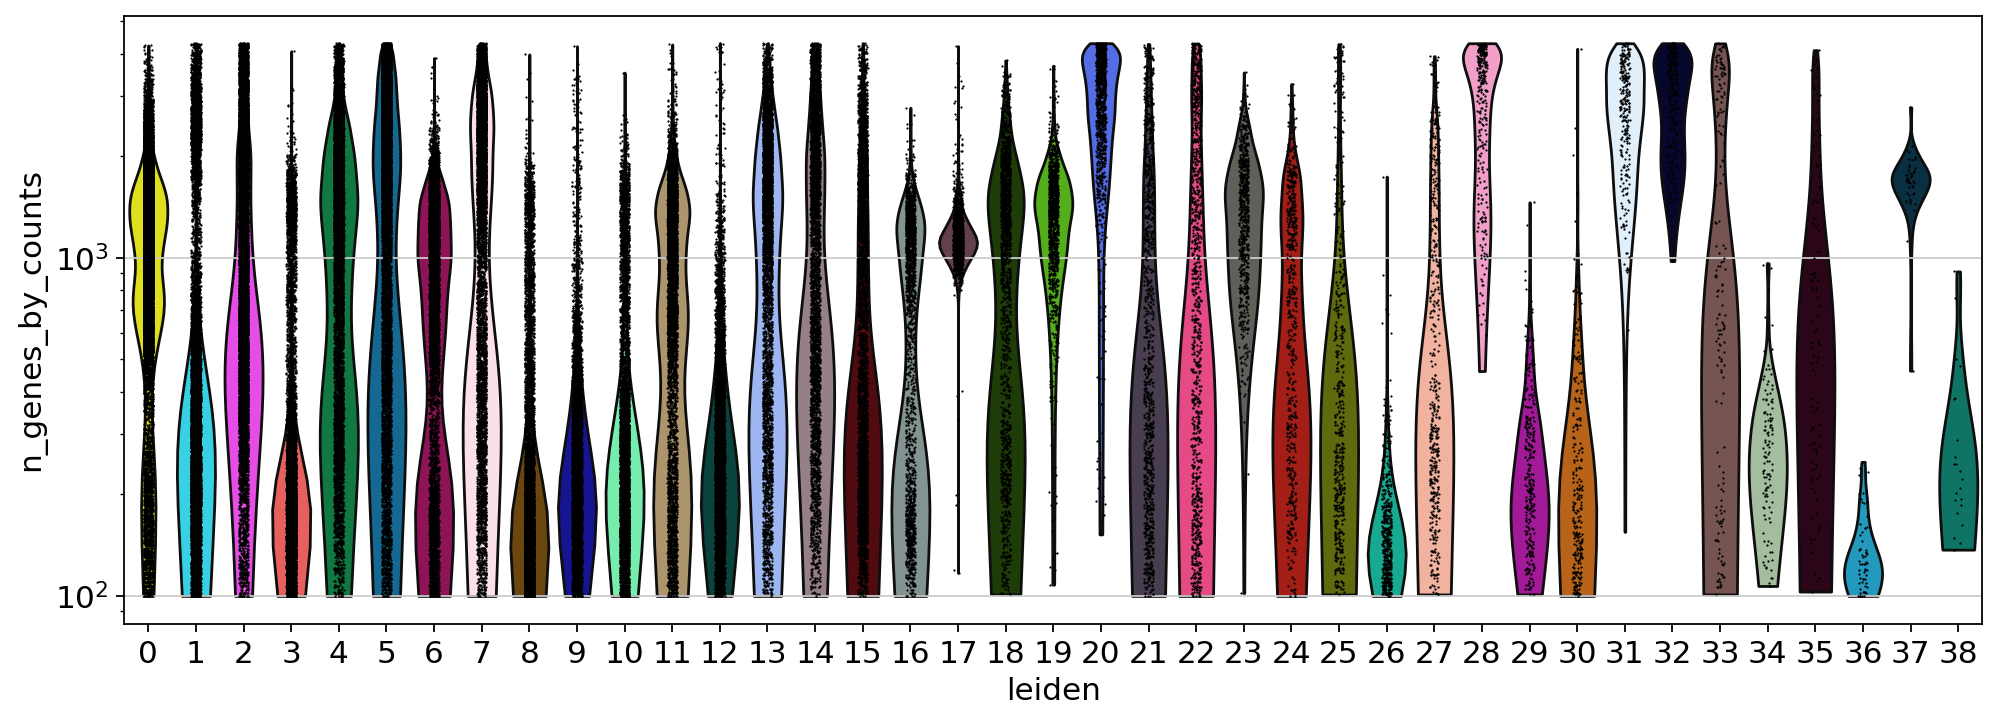

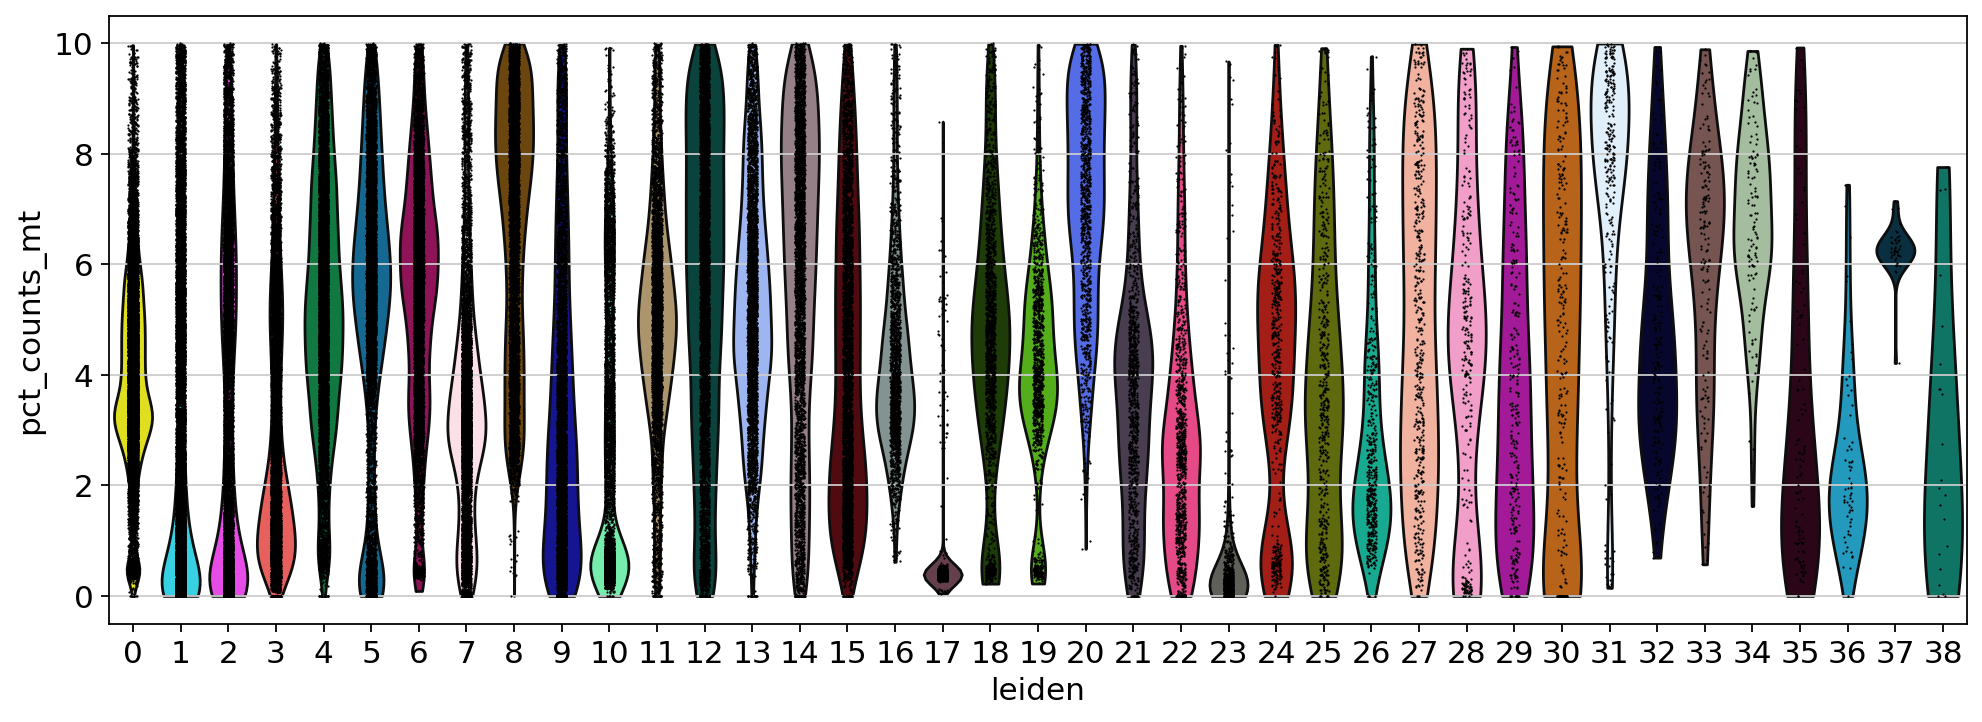

In [65]:
#sc.set_figure_params(figsize=(12,5))
sc.pl.violin(adata_concat,groupby='leiden',keys='n_genes_by_counts',log=True)
sc.pl.violin(adata_concat,groupby='leiden',keys='pct_counts_mt')

In [66]:
cl = '8'
sc.tl.rank_genes_groups(adata_concat,groupby='leiden',groups=[cl],layer='log1p',use_raw=False)
deg_df = sc.get.rank_genes_groups_df(adata_concat, group=cl,log2fc_min=0.5,pval_cutoff=0.05)
deg_df[:30]

names      scores  logfoldchanges          pvals      pvals_adj
0       MT-CO2  108.277809        1.502343   0.000000e+00   0.000000e+00
1       MT-CO1   82.591362        1.202757   0.000000e+00   0.000000e+00
2       MT-CYB   53.075409        1.107937   0.000000e+00   0.000000e+00
3       MT-CO3   48.331791        1.124384   0.000000e+00   0.000000e+00
4      MT-ATP6   42.536434        1.073387   0.000000e+00   0.000000e+00
5      MT-ND4L   40.773148        0.899986   0.000000e+00   0.000000e+00
6       MT-ND3   36.782795        0.804619  2.270605e-273  8.057887e-272
7       MT-ND4   30.476248        0.792262  2.425310e-192  4.575507e-191
8    MTRNR2L12   29.291544        1.586879  3.063677e-178  5.111514e-177
9        RPL12   25.480915        1.313542  4.398346e-137  5.209966e-136
10      MT-ND1   20.084457        0.574366   2.140929e-87   1.488167e-86
11        TPPP    3.258996        1.024667   1.123420e-03   1.500083e-03
12     TRBV5-5    2.934820        0.633527   3.348181e-03   4.327948e-03
13  AC016831.5    2.882689        0.513828   3.954865e-03   5.082891e-03

In [67]:
celltype_mapping_dict = {
    'T cell': [0,3,6,8,10,16,17,19,24,26,],
    'Myeloid cell': [7,9,21,37],
    'B cell': [11],
    'Mast cell': [18],
    'Epithelial cell': [1,2,5,12,14,20,23,25,28,29,30,31,32,33,34,35,36,38],
    'Fibroblast': [13,15],
    'Endothelial cell': [4,27],
    'Cycling cell':[22]
}

# Invert the dictionary
cluster_to_cell_type = {str(cluster): cell_type for cell_type, clusters in celltype_mapping_dict.items() for cluster in clusters}

adata_concat.obs['cell_type'] = pd.Categorical(adata_concat.obs['leiden'].map(cluster_to_cell_type),categories=list(celltype_mapping_dict.keys()))


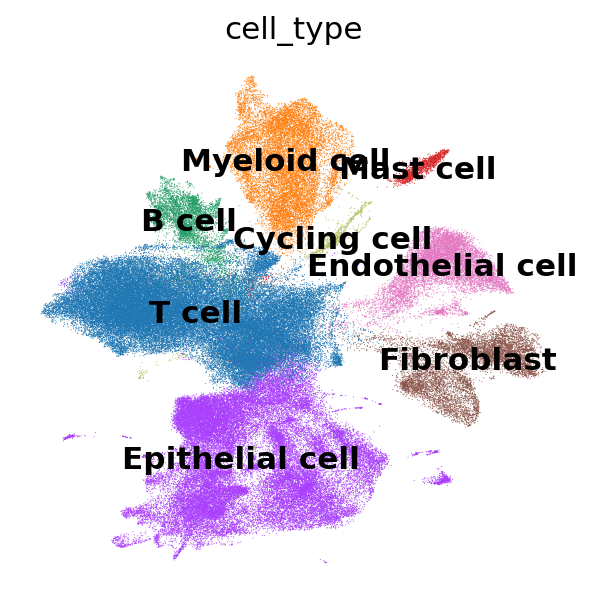

In [68]:
fig, ax= plt.subplots(figsize=(4,4))
sc.pl.umap(adata_concat,color='cell_type',legend_loc='on data',frameon=False,ax=ax,show=False)
plt.tight_layout()
plt.savefig('/home/ak431480/plots/scs_data_celltype_all.png',dpi=300)
plt.show()

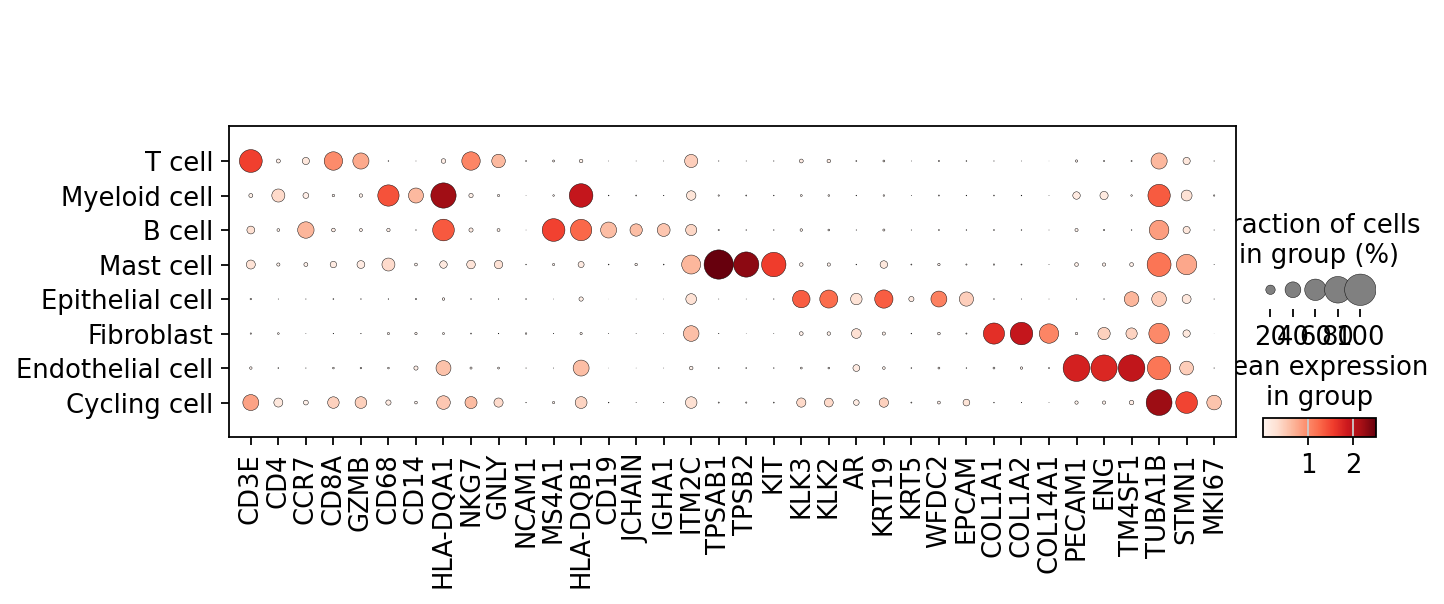

In [69]:
sc.tl.dendrogram(adata_concat,groupby='cell_type')
fig, ax = plt.subplots(figsize=(9,4))
sc.pl.dotplot(adata_concat,groupby='cell_type',var_names=gene_markers, dendrogram=False, use_raw=False, layer='log1p', ax = ax, show=False, vmax=2.5)
plt.tight_layout()
plt.savefig('/home/ak431480/plots/scs_data_celltype_all_dotplot.pdf',dpi=300)
plt.show()

In [70]:

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')
n_cells = len(adata_concat)

adata_concat.write_h5ad(f'/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_{n_cells}_cells_{formatted_date}.h5ad')
adata_concat.obs.to_csv(f'/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_{n_cells}_cells_{formatted_date}.csv')


In [71]:
pd.read_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/annotated_adata_obj_147180_cells_250813.csv',index_col=0)

doublet  doublet_score    sample  type  n_genes_by_counts  \
CGCCAAGAGGGTGTTG-1      0.0       1.297393  CRPC_S01  CRPC               4147   
CATCCACAGCTAGGCA-1      0.0      28.403090  CRPC_S01  CRPC               3667   
CAACCTCCATGTCTCC-1      0.0      28.403090  CRPC_S01  CRPC               4050   
CGGTTAATCGTTGCCT-1      0.0      28.403090  CRPC_S01  CRPC               3833   
CCAATCCAGACATAAC-1      0.0      28.403090  CRPC_S01  CRPC               3736   
...                     ...            ...       ...   ...                ...   
GGGAGATGTAGAAAGG-1      0.0      26.731888    PC_S44    PC                423   
GAGTCCGGTCCGAAGA-1      0.0       0.554882    PC_S44    PC                382   
GTACTTTGTTCCCTTG-1      0.0      26.731888    PC_S44    PC                465   
ACGCCAGGTAAGGGAA-1      0.0      26.731888    PC_S44    PC                314   
AAGACCTTCGGAAATA-1      0.0      26.731888    PC_S44    PC                462   

                    total_counts  total_counts_mt  pct_counts_mt  leiden  \
CGCCAAGAGGGTGTTG-1         16254              459       2.823920       7   
CATCCACAGCTAGGCA-1         15584              788       5.056468       7   
CAACCTCCATGTCTCC-1         16067              568       3.535196       7   
CGGTTAATCGTTGCCT-1         14775              621       4.203046       7   
CCAATCCAGACATAAC-1         14948             1063       7.111319       7   
...                          ...              ...            ...     ...   
GGGAGATGTAGAAAGG-1          1042               64       6.142035       1   
GAGTCCGGTCCGAAGA-1           715               65       9.090909      21   
GTACTTTGTTCCCTTG-1           665               65       9.774436       1   
ACGCCAGGTAAGGGAA-1           893               52       5.823068       1   
AAGACCTTCGGAAATA-1           661               58       8.774584       1   

                          cell_type  
CGCCAAGAGGGTGTTG-1     Myeloid cell  
CATCCACAGCTAGGCA-1     Myeloid cell  
CAACCTCCATGTCTCC-1     Myeloid cell  
CGGTTAATCGTTGCCT-1     Myeloid cell  
CCAATCCAGACATAAC-1     Myeloid cell  
...                             ...  
GGGAGATGTAGAAAGG-1  Epithelial cell  
GAGTCCGGTCCGAAGA-1     Myeloid cell  
GTACTTTGTTCCCTTG-1  Epithelial cell  
ACGCCAGGTAAGGGAA-1  Epithelial cell  
AAGACCTTCGGAAATA-1  Epithelial cell  

[147180 rows x 10 columns]

## XCLTK metrics

In [118]:
obs_data = pd.read_csv('./preprocessed_h5ad/annotated_adata_obj_135473_cells_250609.csv',index_col=0)
type_mapping_dict = obs_data[['sample','type']].groupby('sample').first().to_dict()['type']

In [146]:
pivot_table = pd.pivot_table(obs_data, index='cell_type', columns='sample', aggfunc='size', fill_value=0).T
pivot_table['total'] = pivot_table.sum(axis=1)
pivot_table['type'] = pivot_table.index.map(type_mapping_dict)
#pivot_table.sort_values('Epithelial cell',ascending=False)[:28]
df = pivot_table[pivot_table['Epithelial cell'] >=100].sort_values('Epithelial cell',ascending=False)
df.index.tolist()

['CRPC_S05',
 'HSPC_S21',
 'HSPC_S30',
 'PC_S43',
 'HSPC_S24',
 'HSPC_S14',
 'HSPC_S16',
 'HSPC_S10',
 'PC_S37',
 'PC_S39',
 'PC_S35',
 'HSPC_S26',
 'HSPC_S22',
 'PC_S40',
 'HSPC_S15',
 'HSPC_S20',
 'HSPC_S25',
 'HSPC_S18',
 'PC_S33',
 'HSPC_S29',
 'HSPC_S11',
 'PC_S42',
 'HSPC_S17',
 'HSPC_S28',
 'CRPC_S06',
 'HSPC_S08',
 'HSPC_S19',
 'CRPC_S04',
 'PC_S41',
 'PC_S34']

In [139]:
#sample = 'HSPC_S08'
for sample in df.index.tolist():
    xcltk_barcodes = pd.read_csv(f'/scratch/svc_td_compbio/users/kiviaho/xcltk_outs/{sample}/barcodes.tsv',sep='\t',header=None)
    overlap = len(obs_data[((obs_data['sample'] == sample) & (obs_data['cell_type'] != 'Epithelial cell'))].index.intersection(xcltk_barcodes[0]))
    print(f'{sample}: {overlap} epithelial cells survived xcltk filtering')

CRPC_S05: 2723 epithelial cells survived xcltk filtering
HSPC_S21: 545 epithelial cells survived xcltk filtering
HSPC_S30: 1277 epithelial cells survived xcltk filtering
PC_S43: 4320 epithelial cells survived xcltk filtering
HSPC_S24: 1317 epithelial cells survived xcltk filtering
HSPC_S14: 423 epithelial cells survived xcltk filtering
HSPC_S16: 1919 epithelial cells survived xcltk filtering
HSPC_S10: 1625 epithelial cells survived xcltk filtering
PC_S37: 6533 epithelial cells survived xcltk filtering
PC_S39: 4710 epithelial cells survived xcltk filtering
PC_S35: 5824 epithelial cells survived xcltk filtering
HSPC_S26: 68 epithelial cells survived xcltk filtering
HSPC_S22: 6630 epithelial cells survived xcltk filtering
PC_S40: 1177 epithelial cells survived xcltk filtering
HSPC_S15: 986 epithelial cells survived xcltk filtering
HSPC_S20: 717 epithelial cells survived xcltk filtering
HSPC_S25: 541 epithelial cells survived xcltk filtering
HSPC_S18: 178 epithelial cells survived xcltk fi

<Axes: xlabel='total', ylabel='Count'>

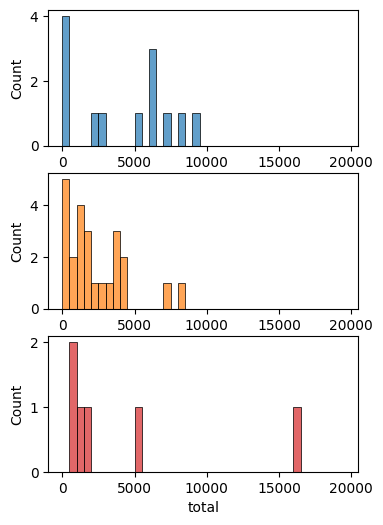

In [134]:
#ctype_key = 'Epithelial cell'
ctype_key = 'total'
bin_range = np.arange(0,20000,500)

pal = sns.color_palette(sns.color_palette('tab10')[:4])
fig, axs = plt.subplots(3,1,figsize=(4,6))

sns.histplot(pivot_table.loc[pivot_table['type']=='PC',ctype_key],color=pal[0],bins=bin_range,ax = axs[0], alpha=0.7)
sns.histplot(pivot_table.loc[pivot_table['type']=='HSPC',ctype_key],color=pal[1],bins=bin_range,ax = axs[1], alpha=0.7)
sns.histplot(pivot_table.loc[pivot_table['type']=='CRPC',ctype_key],color=pal[3],bins=bin_range,ax = axs[2], alpha=0.7)

## Integrating XClone results

In [2]:
import xclone
import anndata as ad
import gc
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import palettable
from sklearn.decomposition import PCA



import warnings
warnings.filterwarnings("ignore")

#'CRPC_S01','CRPC_S02','CRPC_S03','HSPC_S07','HSPC_S09','HSPC_S12','HSPC_S13','HSPC_S23','HSPC_S27','HSPC_S31''PC_S32','PC_S36','PC_S38','PC_S44'
samples_list = ['CRPC_S04','CRPC_S05','CRPC_S06',
'HSPC_S08','HSPC_S10','HSPC_S11',
'HSPC_S14','HSPC_S15','HSPC_S16','HSPC_S17','HSPC_S18','HSPC_S19','HSPC_S20',
'HSPC_S21','HSPC_S22','HSPC_S24','HSPC_S25','HSPC_S26',
'HSPC_S28','HSPC_S29','HSPC_S30',
'PC_S33','PC_S34','PC_S35','PC_S37','PC_S39',
'PC_S40','PC_S41','PC_S42','PC_S43']


def assign_cna_states(cna_probs):
    """Assigns CNA states to cells based on the highest probability in a cell*gene*cnv state array.

    Args:
        cna_probs: A NumPy array of shape (num_cells, num_genes, num_cna_states)
                   representing the probabilities of each CNA state for each cell and gene.

    Returns:
        A NumPy array of shape (num_cells, num_genes) containing the assigned CNA states 
        for each cell and gene.
    """

    num_cells, num_genes, _ = cna_probs.shape
    cna_states = np.argmax(cna_probs, axis=2)  # Find the index of the highest probability state

    return cna_states

from scipy.stats import mode

def percentage_mode_match(array):
    percentages = []
    for col in range(array.shape[1]):
        col_data = array[:, col]
        most_common_value = mode(col_data, keepdims=True).mode
        match_count = np.sum(col_data == most_common_value)
        percentage = (match_count / len(col_data))
        percentages.append(percentage)
    return percentages



use_layer = "prob1_merge"
cnv_clustering_key = 'kmeans_cnv'

# Define colors
## neutral state
white_c = palettable.colorbrewer.diverging.PuOr_3.mpl_colors[1]
## loh state
loh_c = palettable.colorbrewer.diverging.BrBG_4.mpl_colors[-2] ## cyan-blue
## loss state
loss_c = palettable.colorbrewer.diverging.RdBu_8.mpl_colors[-1] ## dark blue
## gain state
gain_c = palettable.colorbrewer.diverging.RdBu_8.mpl_colors[0] ## red

#if cm_name == "combine_cmap":
color_map = [loss_c, loh_c, white_c, gain_c]


(Running XClone 0.3.8)
2025-08-18 06:06:33


### Create a simiplified adata structure for plotting

In [3]:
adata_cnv_profiles_dict = {}
#sample = 'HSPC_S18'

for sample in tqdm(samples_list):

    adata_xclone = sc.read_h5ad(f'/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/lyu_2024_xclone_analysis/xclone_outs/{sample}/data/combined_final.h5ad')

    # Subset to just the non-reference epithelial cells
    adata_xclone = adata_xclone[adata_xclone.obs['cell_type'] == 'Epithelial cell']

    adata_xclone_simple = ad.AnnData(X=assign_cna_states(adata_xclone.layers[use_layer]),
                                    obs = adata_xclone.obs.copy(),
                                    var = adata_xclone.var.copy())
    adata_xclone_simple.layers[use_layer] = adata_xclone.layers[use_layer].copy()
    adata_xclone_simple.obs['sample'] = sample
    adata_xclone_simple.obs['type'] = sample.split('_')[0]

    # Set the index

    adata_xclone_simple.var = adata_xclone_simple.var[['GeneName','GeneID','chr','start','stop','arm','chr_arm','band','gene_index']]

    # Delete the adata object
    del adata_xclone
    gc.collect()

    adata_cnv_profiles_dict[sample] = adata_xclone_simple.copy()
    

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [06:00<00:00, 12.02s/it]


### Aditional plotting

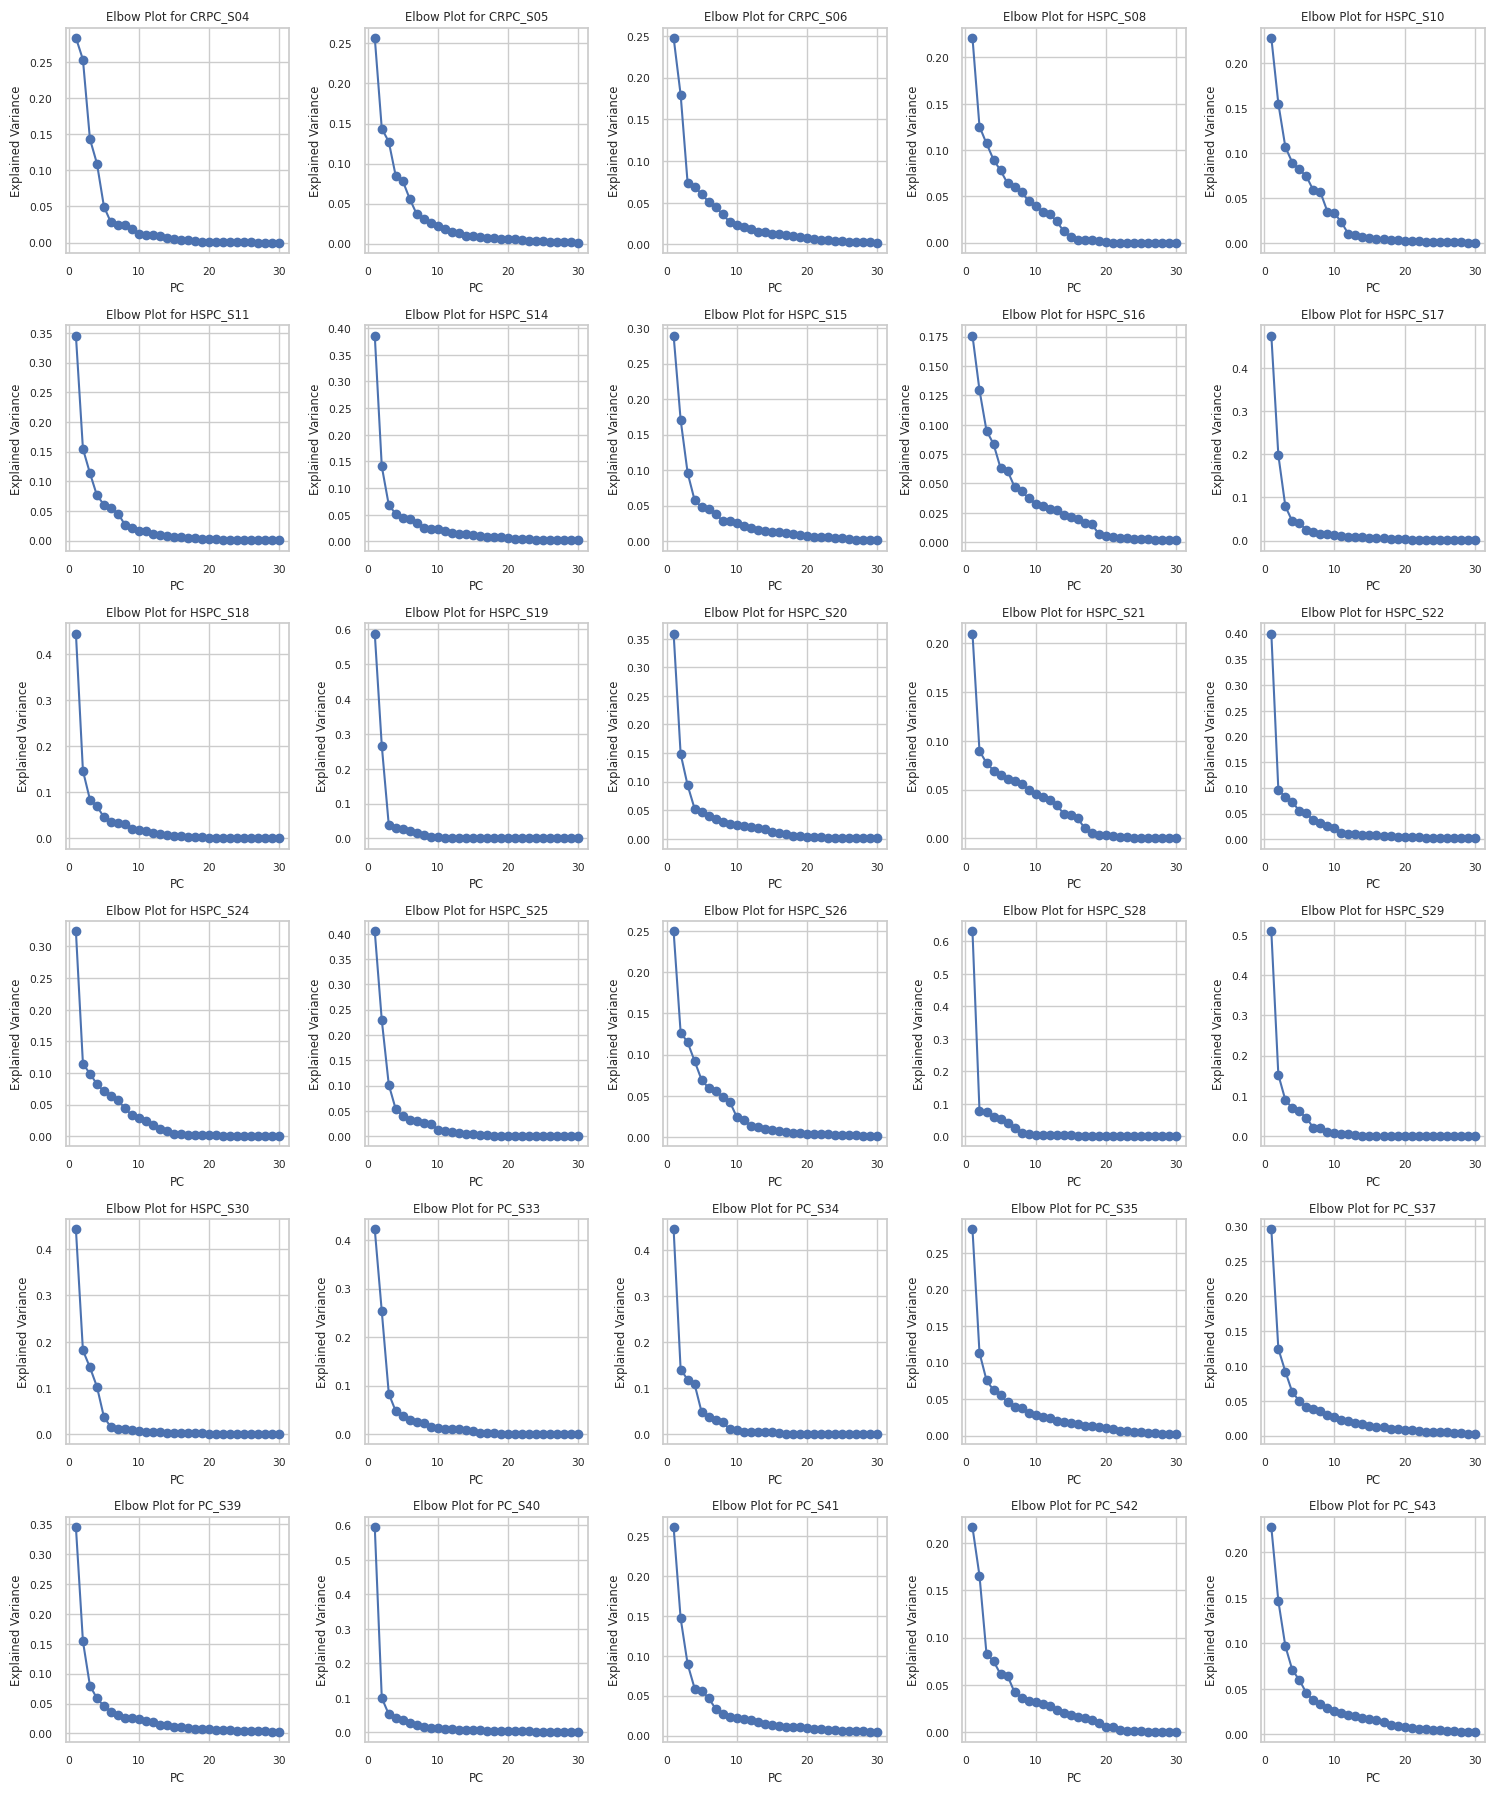

In [ ]:
sns.set_theme(style='whitegrid',font_scale=0.7)
# 6 rows × 5 columns = 30 slots, enough for 29 samples
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 18))

for i, sample in enumerate(samples_list):
    adata = adata_cnv_profiles_dict[sample].copy()
    X = adata.X

    # Compute PCA
    pca = PCA(n_components=30)
    pca.fit(X)

    # Plot elbow plot
    ax = axes[i // 5, i % 5]
    ax.plot(range(1, 31), pca.explained_variance_ratio_, marker='o')
    ax.set_title(f'Elbow Plot for {sample}')
    ax.set_xlabel('PC')
    ax.set_ylabel('Explained Variance')
    ax.grid(True)

# Hide any unused subplot (only one in this case)
if len(samples_list) < 30:
    for j in range(len(samples_list), 30):
        fig.delaxes(axes[j // 5, j % 5])

plt.tight_layout()

plt.savefig('./plots/CNV_elbowplots.pdf')
plt.show()


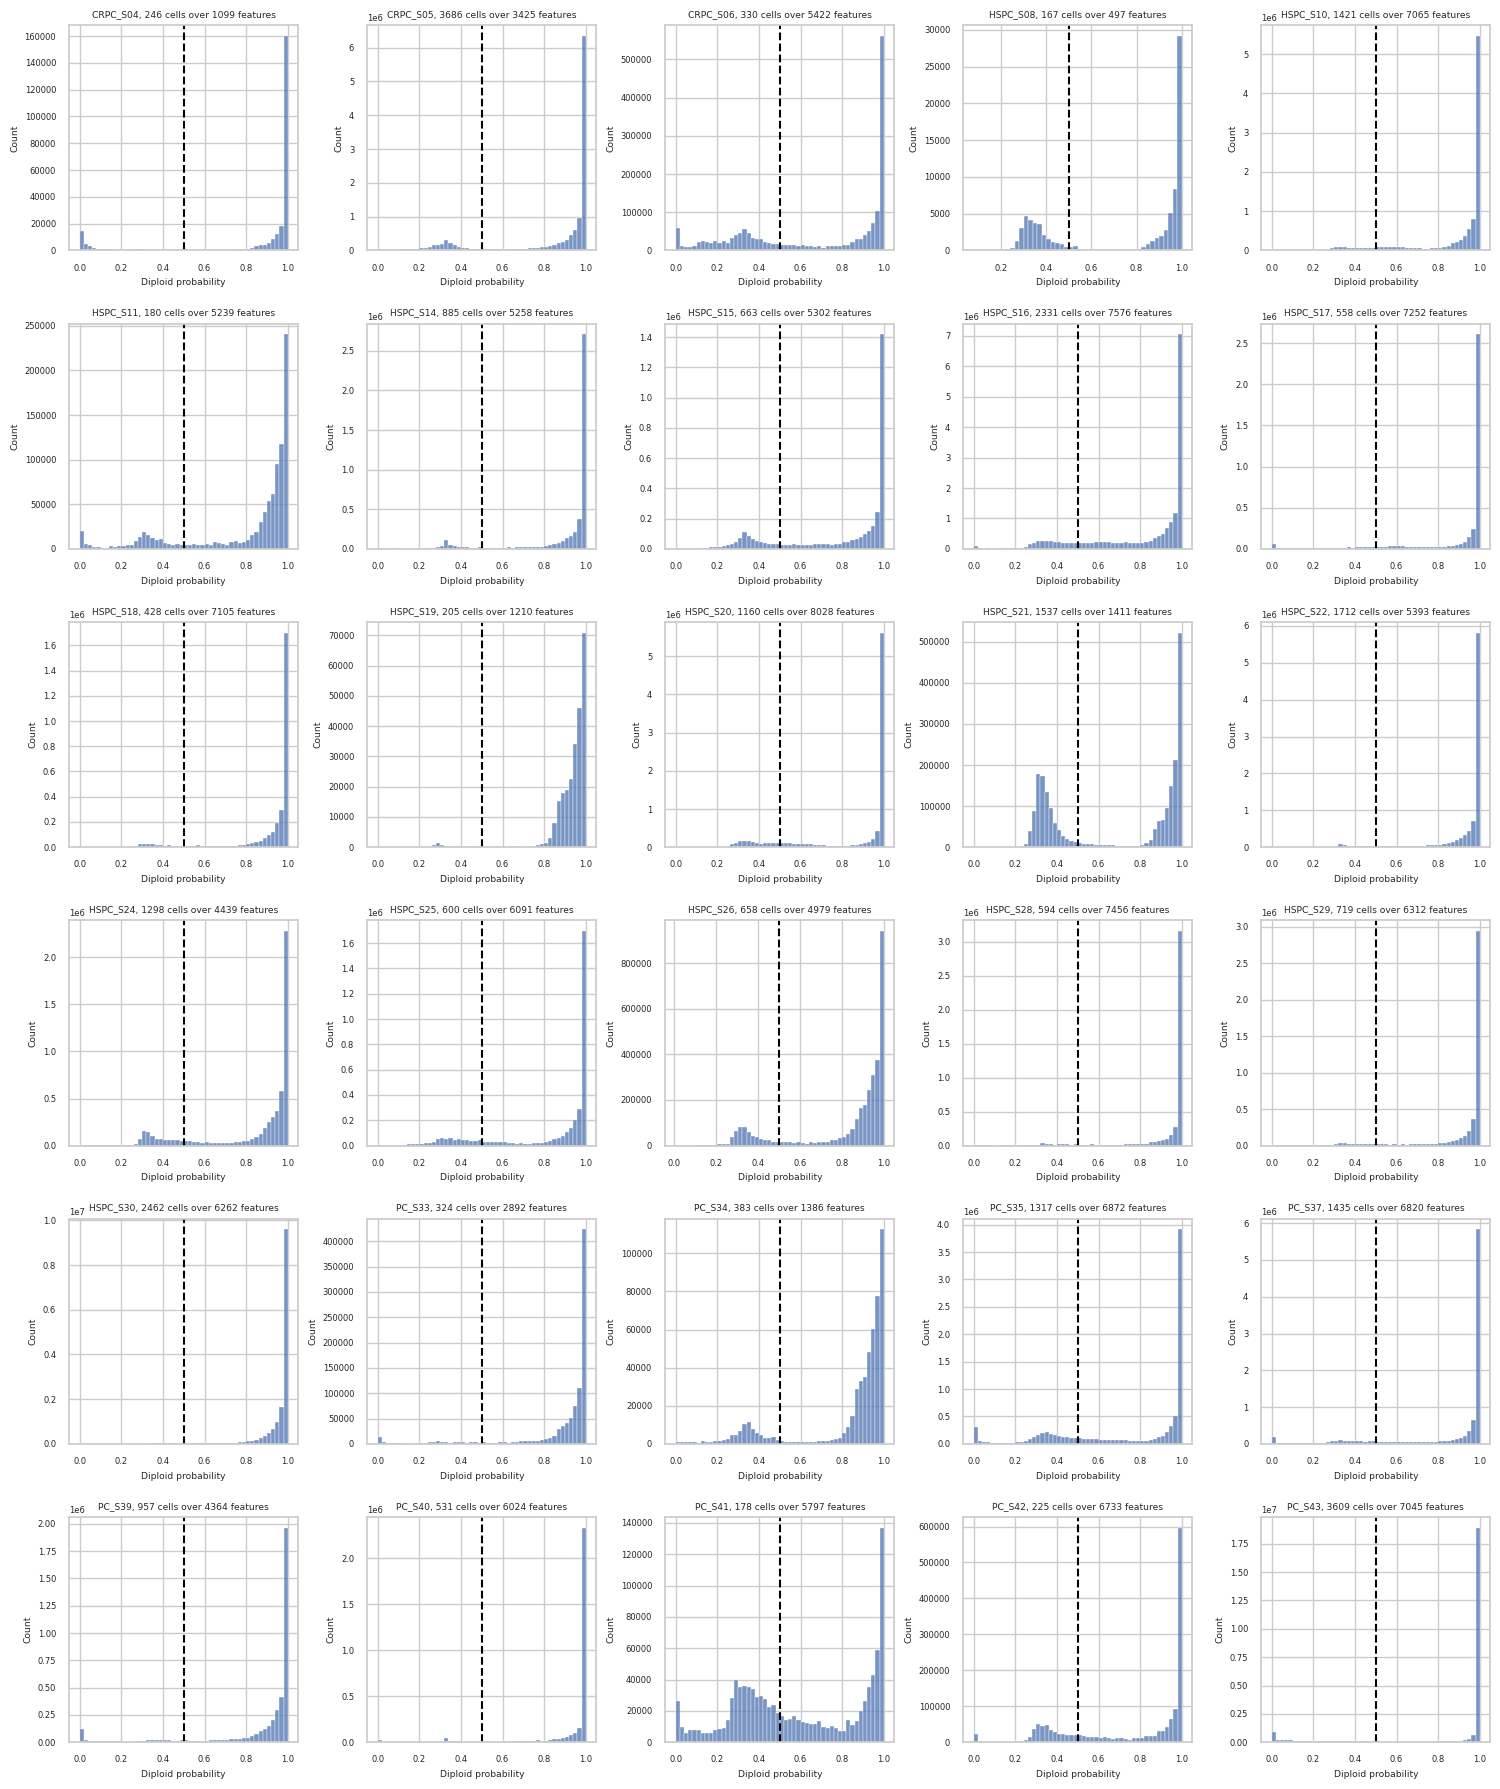

In [ ]:
sns.set_theme(style='whitegrid',font_scale=0.55)
# 6 rows × 5 columns = 30 slots, enough for 29 samples
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15, 18))

for i, sample in enumerate(samples_list):
    adata = adata_cnv_profiles_dict[sample].copy()
    n_cells, n_features = adata.shape

    # Plot elbow plot
    ax = axes[i // 5, i % 5]

    #sns.histplot((adata.layers[use_layer][:,:,2] < 0.5).sum(axis=1),kde=True,binwidth=10,ax=ax)
    sns.histplot(adata.layers[use_layer][:,:,2].flatten(),ax=ax,binwidth=0.02)
    ax.axvline(0.5,linestyle='--',color='black')
    ax.set_title(f'{sample}, {n_cells} cells over {n_features} features')
    ax.set_xlabel('Diploid probability')
    
    
# Hide any unused subplot (only one in this case)
if len(samples_list) < 30:
    for j in range(len(samples_list), 30):
        fig.delaxes(axes[j // 5, j % 5])

plt.tight_layout()

plt.savefig('./plots/CNV_diploid_probability_histogram.pdf')
plt.show()


### CNA profiles 

In [21]:
def analyze_cancer_clusters(adata, chr_arm_cnv_threshold = 0.75, mode_match_pct_threshold=0.75):
    def percentage_mode_match(array):
        percentages = []
        for col in range(array.shape[1]):
            col_data = array[:, col]
            most_common_value = mode(col_data, keepdims=True).mode
            match_count = np.sum(col_data == most_common_value)
            percentage = match_count / len(col_data)
            percentages.append(percentage)
        return percentages

    status_mapping_dict = {}
    obs_data = adata.obs.copy()

    # Prepare CNV data
    var_data = pd.DataFrame(adata.X.T, columns=adata.obs_names, index=adata.var_names)
    var_data['chr_arm'] = adata.var['chr_arm'].copy()
    var_data = var_data.groupby('chr_arm').mean().round(0).T
    var_data['cnv_leiden'] = adata.obs['kmeans_cnv'].copy()

    for cl in np.unique(adata.obs['kmeans_cnv']):
        # Subset cluster data
        var_data_cluster = var_data[var_data['cnv_leiden'] == cl].copy().drop(columns='cnv_leiden')
        chr_arm_aberration_pcts = (var_data_cluster != 2).sum() / len(var_data_cluster)
        above_threshold_chr_arms = chr_arm_aberration_pcts[chr_arm_aberration_pcts > chr_arm_cnv_threshold]

        # Get raw CNV matrix for this cluster
        cluster_indices = adata.obs['kmeans_cnv'] == cl
        cluster_array = adata.X[cluster_indices, :]
        mode_match_scores = percentage_mode_match(cluster_array)
        mean_mode_match = np.mean(mode_match_scores)

        # Determine status
        if len(above_threshold_chr_arms) > 0 and mean_mode_match > mode_match_pct_threshold:
            aberrated_chromosome_arms = ', '.join(above_threshold_chr_arms.index.tolist())
            print(f'Cluster {cl}: CNVs in {aberrated_chromosome_arms} | Mode Match: {mean_mode_match:.2f}')
            status_mapping_dict[cl] = 'CNVpos cancer'
        else:
            print(f'Cluster {cl}: No CNVs or low mode match | Mode Match: {mean_mode_match:.2f}')
            status_mapping_dict[cl] = 'Benign'

    # Map status back to obs
    obs_data['CNV_status'] = obs_data['kmeans_cnv'].map(status_mapping_dict)
    return obs_data

len_dict ={}
for k in adata_cnv_profiles_dict:
    len_dict[k] = len(adata_cnv_profiles_dict[k])
samples_sorted_by_n = pd.DataFrame(len_dict,index=['length']).T.sort_values('length',ascending=False).index.tolist()

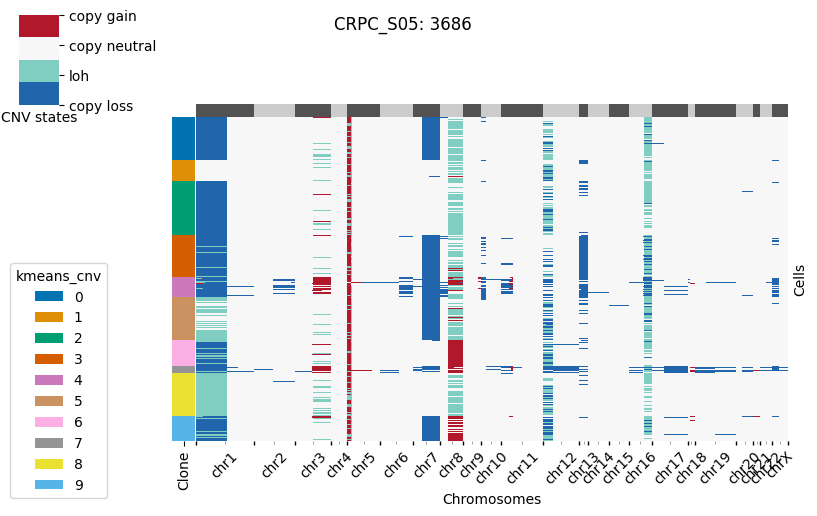

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 1p, 5p, 7q, 16q | Mode Match: 0.97
Cluster 1: CNVs in 5p, 8q, 12p | Mode Match: 0.97
Cluster 2: CNVs in 1p, 5p | Mode Match: 0.97
Cluster 3: CNVs in 1p, 5p, 7q, 13q, 16q | Mode Match: 0.96
Cluster 4: CNVs in 1p, 5p, 7q, 10p, 13q, 16q, Xp | Mode Match: 0.91
Cluster 5: CNVs in 5p, 7q, 16q | Mode Match: 0.95
Cluster 6: CNVs in 1p, 5p, 8q, 12p | Mode Match: 0.95
Cluster 7: CNVs in 1p, 3q, 5p, 8q, 12q, 16q, 17q, 19p, Xp | Mode Match: 0.84
Cluster 8: CNVs in 1p, 5p, 8q, 12p | Mode Match: 0.97
Cluster 9: CNVs in 1p, 5p, 7q, 8q, 12p, 16q | Mode Match: 0.95


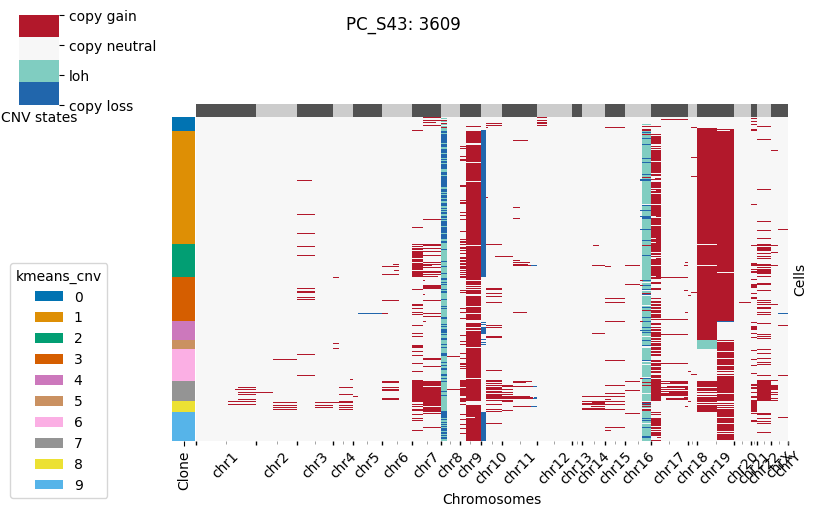

<Figure size 640x480 with 0 Axes>

Cluster 0: No CNVs or low mode match | Mode Match: 0.95
Cluster 1: CNVs in 8p, 9q, 10p, 16q, 19p, 19q | Mode Match: 0.98
Cluster 2: CNVs in 7p, 8p, 9q, 10p, 16q, 17p, 19p, 19q | Mode Match: 0.95
Cluster 3: CNVs in 8p, 9q, 16q, 19p, 19q | Mode Match: 0.96
Cluster 4: CNVs in 8p, 9q, 16q, 19p | Mode Match: 0.95
Cluster 5: CNVs in 8p, 9q, 16q, 19p | Mode Match: 0.95
Cluster 6: CNVs in 8p, 9q, 16q, 19q | Mode Match: 0.96
Cluster 7: CNVs in 7p, 7q, 8p, 9q, 16q, 17p, 19p, 19q, 22q | Mode Match: 0.90
Cluster 8: CNVs in 7q, 8p, 16q, 21q | Mode Match: 0.87
Cluster 9: CNVs in 8p, 9q, 10p, 16q, 19q | Mode Match: 0.97


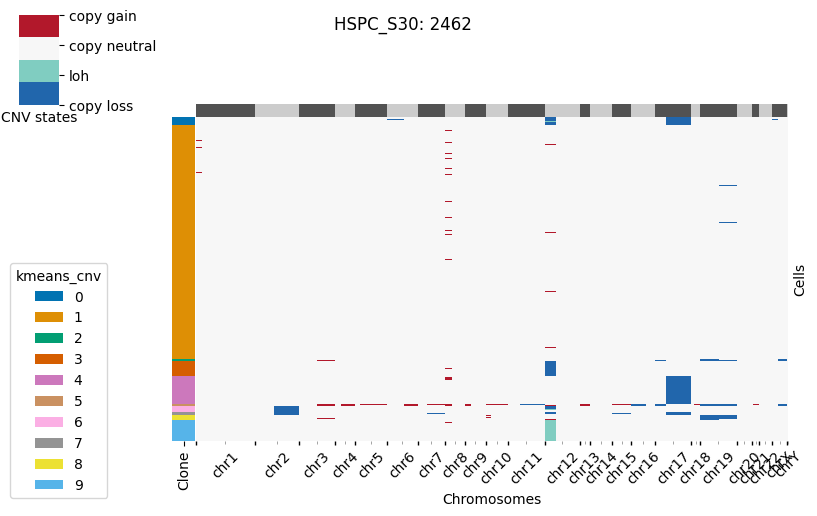

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 12p, 17q | Mode Match: 0.99
Cluster 1: No CNVs or low mode match | Mode Match: 1.00
Cluster 2: CNVs in 19p, 19q, Xq | Mode Match: 0.96
Cluster 3: CNVs in 12p | Mode Match: 1.00
Cluster 4: CNVs in 17q | Mode Match: 1.00
Cluster 5: CNVs in 3q, 4q, 6q, 10p, 10q, 13q, 15q, 16p, 17p, 19p, 19q, Xq | Mode Match: 0.93
Cluster 6: CNVs in 2q | Mode Match: 0.99
Cluster 7: CNVs in 2q, 17q | Mode Match: 0.98
Cluster 8: CNVs in 19p | Mode Match: 0.98
Cluster 9: CNVs in 12p | Mode Match: 1.00


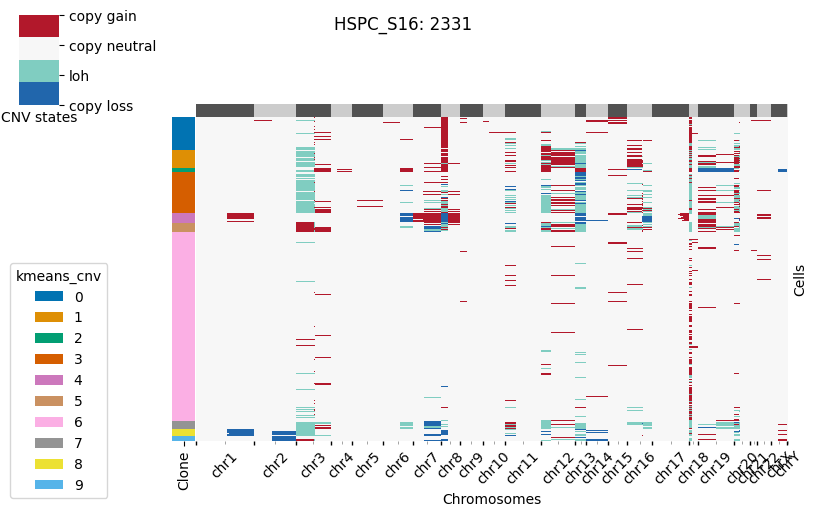

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 8p, 18p | Mode Match: 0.96
Cluster 1: CNVs in 8p, 12p, 13q, 18p, 20p | Mode Match: 0.91
Cluster 2: CNVs in 3q, 4q, 6q, 8p, 12p, 13q, 18p, 19p, 19q, 20p | Mode Match: 0.91
Cluster 3: CNVs in 3p, 13q, 18p | Mode Match: 0.91
Cluster 4: CNVs in 1q, 6q, 7p, 7q, 8p, 8q, 13q, 16q, 19p | Mode Match: 0.94
Cluster 5: CNVs in 3p, 8p, 12p, 13q, 18p, 20p | Mode Match: 0.88
Cluster 6: No CNVs or low mode match | Mode Match: 0.99
Cluster 7: CNVs in 3p, 3q, 6q, 7q, 11p, 12p, 16q, 18p, 19q, 20p | Mode Match: 0.91
Cluster 8: CNVs in 1q, 3p, 13q, 18p | Mode Match: 0.89
Cluster 9: CNVs in 2q | Mode Match: 0.93


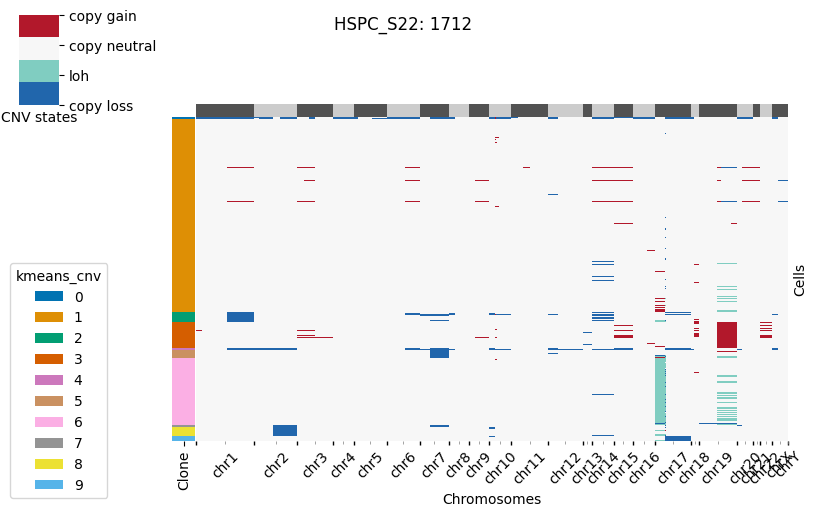

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 1p, 1q, 2p, 2q, 4p, 6p, 6q, 7q, 8p, 10p, 10q, 12p, 14q, 16p, 16q, 17q, Xp | Mode Match: 0.93
Cluster 1: No CNVs or low mode match | Mode Match: 0.99
Cluster 2: CNVs in 1q | Mode Match: 0.94
Cluster 3: CNVs in 19q | Mode Match: 0.97
Cluster 4: CNVs in 1q, 2p, 2q, 6q, 7p, 7q, 8p, 10p, 10q, 12p, 14q, 15q, 17q, 18p, Xp | Mode Match: 0.88
Cluster 5: CNVs in 7q | Mode Match: 0.98
Cluster 6: CNVs in 17p | Mode Match: 0.99
Cluster 7: CNVs in 2q, 7q | Mode Match: 0.98
Cluster 8: CNVs in 2q | Mode Match: 0.99
Cluster 9: CNVs in 17q | Mode Match: 0.98


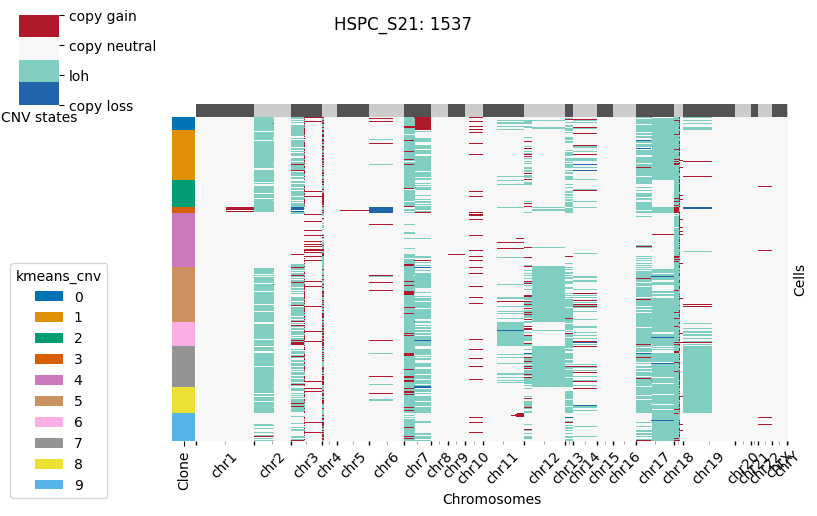

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 2p, 4p, 7p, 7q, 17p, 17q, 18p | Mode Match: 0.88
Cluster 1: CNVs in 2p, 3p, 4p, 7p, 17p, 17q, 18p | Mode Match: 0.95
Cluster 2: CNVs in 2p, 4p, 7p, 18p | Mode Match: 0.93
Cluster 3: CNVs in 2p, 3p, 4p, 6p, 7q, 17p, 17q, 18p | Mode Match: 0.87
Cluster 4: CNVs in 18p | Mode Match: 0.96
Cluster 5: CNVs in 2p, 4p, 7p, 12q, 17p, 17q, 18p | Mode Match: 0.92
Cluster 6: CNVs in 2p, 3p, 4p, 7p, 7q, 11q, 17p, 17q, 18p | Mode Match: 0.91
Cluster 7: CNVs in 2p, 3p, 4p, 7p, 7q, 12q, 17p, 17q, 18p, 19p | Mode Match: 0.92
Cluster 8: CNVs in 2p, 3p, 4p, 7p, 7q, 17p, 17q, 18p, 19p | Mode Match: 0.94
Cluster 9: CNVs in 4p, 7p, 17q, 18p | Mode Match: 0.93


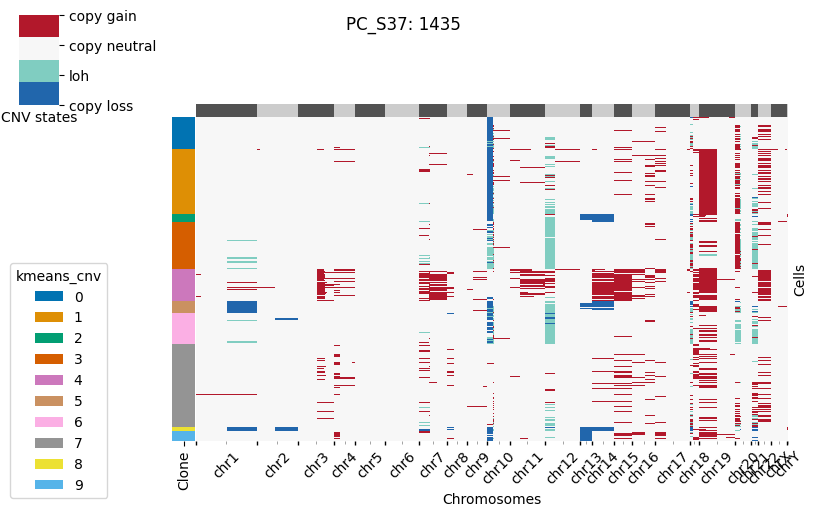

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 10p | Mode Match: 0.97
Cluster 1: CNVs in 10p, 19p | Mode Match: 0.96
Cluster 2: CNVs in 10p, 14q | Mode Match: 0.96
Cluster 3: CNVs in 10p, 12p, 18p, 20p, 21q | Mode Match: 0.97
Cluster 4: CNVs in 7q, 14q, 15q, 19p, 22q | Mode Match: 0.90
Cluster 5: CNVs in 1q, 10p, 12p, 18p | Mode Match: 0.94
Cluster 6: CNVs in 10p, 12p, 20p | Mode Match: 0.96
Cluster 7: No CNVs or low mode match | Mode Match: 0.95
Cluster 8: CNVs in 1q, 2q, 10p, 13q, 14q, 18p, 21q | Mode Match: 0.96
Cluster 9: CNVs in 13q | Mode Match: 0.96


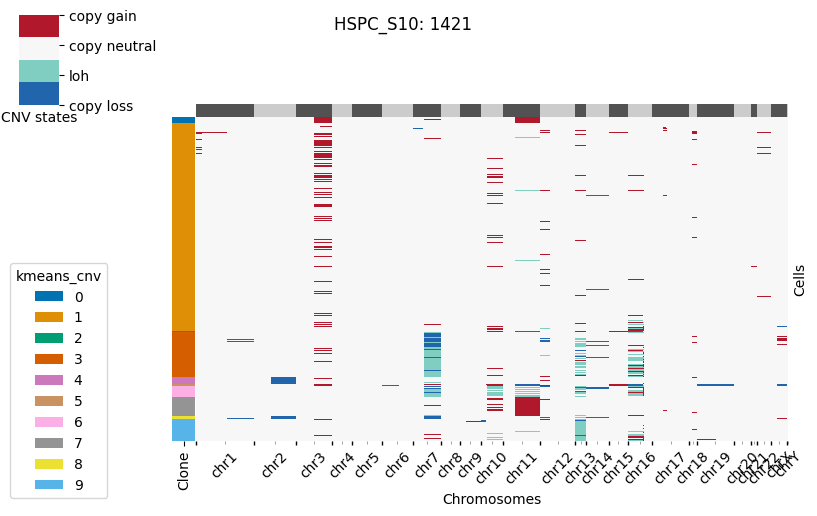

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3q, 11q | Mode Match: 0.99
Cluster 1: No CNVs or low mode match | Mode Match: 0.99
Cluster 2: CNVs in 3q, 7q, 10q, 11q, 16p | Mode Match: 0.95
Cluster 3: CNVs in 7q | Mode Match: 0.96
Cluster 4: CNVs in 2q | Mode Match: 0.98
Cluster 5: CNVs in 3q, 7q, 10q, 11q, 15q, 16p, 19p, Xq | Mode Match: 0.95
Cluster 6: CNVs in 7q, 10q | Mode Match: 0.95
Cluster 7: CNVs in 11q | Mode Match: 0.99
Cluster 8: CNVs in 2q, 7q | Mode Match: 0.96
Cluster 9: CNVs in 13q | Mode Match: 0.97


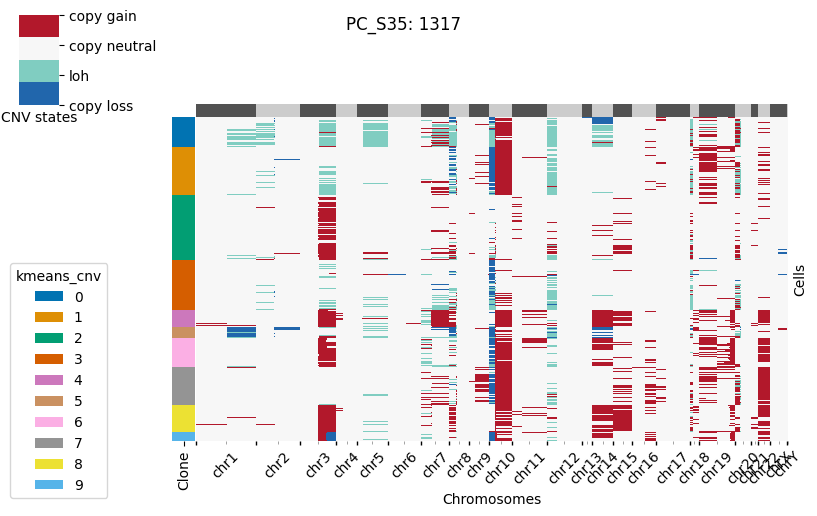

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3q, 5q, 8p, 10p, 10q, 12p, 14q, 18p, 20p | Mode Match: 0.87
Cluster 1: CNVs in 10p, 10q | Mode Match: 0.92
Cluster 2: CNVs in 3q | Mode Match: 0.95
Cluster 3: CNVs in 10p | Mode Match: 0.94
Cluster 4: CNVs in 3q, 7q, 10q, 14q, 15q, 22q | Mode Match: 0.91
Cluster 5: CNVs in 1q, 8p, 10p, 14q | Mode Match: 0.89
Cluster 6: CNVs in 3q, 10p, 10q | Mode Match: 0.91
Cluster 7: CNVs in 10q, 20p, 22q | Mode Match: 0.91
Cluster 8: CNVs in 3q, 14q, 15q | Mode Match: 0.92
Cluster 9: CNVs in 3q, 10p, 14q, 22q | Mode Match: 0.94


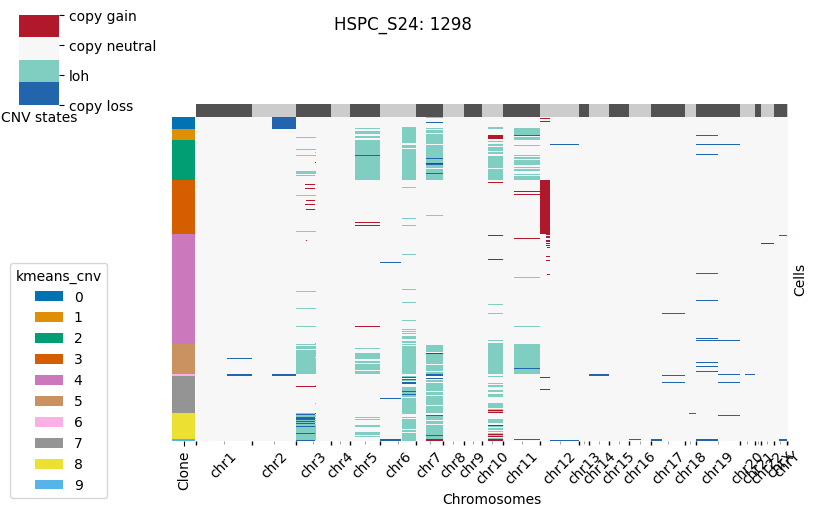

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 2q | Mode Match: 0.97
Cluster 1: CNVs in 6q, 7q, 11q | Mode Match: 0.95
Cluster 2: CNVs in 5q, 6q, 7q, 10q | Mode Match: 0.96
Cluster 3: CNVs in 12p | Mode Match: 0.99
Cluster 4: No CNVs or low mode match | Mode Match: 0.99
Cluster 5: CNVs in 3p, 6q, 7q, 10q, 11q | Mode Match: 0.96
Cluster 6: CNVs in 1q, 2q, 7q, 14q | Mode Match: 0.89
Cluster 7: CNVs in 7q | Mode Match: 0.97
Cluster 8: CNVs in 3p, 7q | Mode Match: 0.96
Cluster 9: CNVs in 6p, 6q, 7q, 10q, 19p, Xq | Mode Match: 0.93


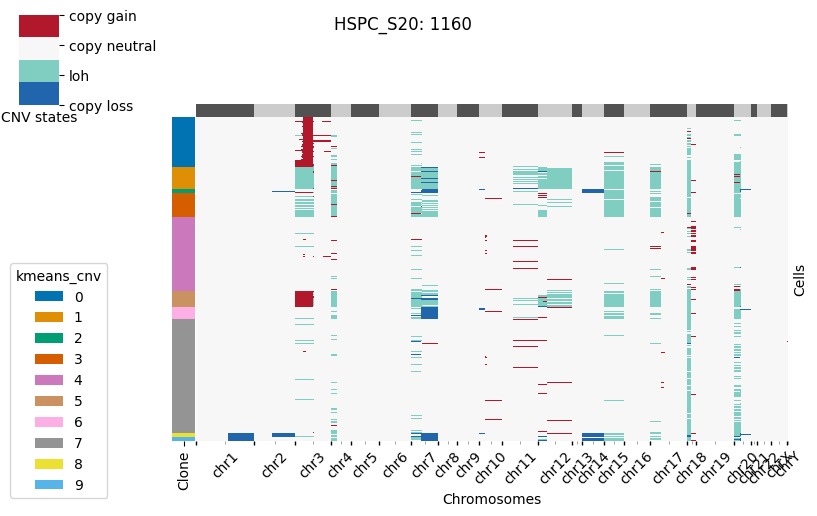

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3p | Mode Match: 0.97
Cluster 1: CNVs in 3p, 4p, 7p, 7q, 12p, 12q, 15q, 17p, 18p, 20p | Mode Match: 0.95
Cluster 2: CNVs in 7q, 14q, 18p, 20p | Mode Match: 0.91
Cluster 3: CNVs in 4p, 7p, 15q, 18p, 20p | Mode Match: 0.94
Cluster 4: No CNVs or low mode match | Mode Match: 0.98
Cluster 5: CNVs in 3p, 4p, 7p, 7q, 15q, 17p, 18p, 20p | Mode Match: 0.94
Cluster 6: CNVs in 7q, 18p, 20p | Mode Match: 0.95
Cluster 7: CNVs in 18p | Mode Match: 0.98
Cluster 8: CNVs in 1q, 2q, 7q, 14q, 18p, 20p | Mode Match: 0.93
Cluster 9: CNVs in 1q, 4p, 7q, 14q, 15q, 18p, 20p | Mode Match: 0.94


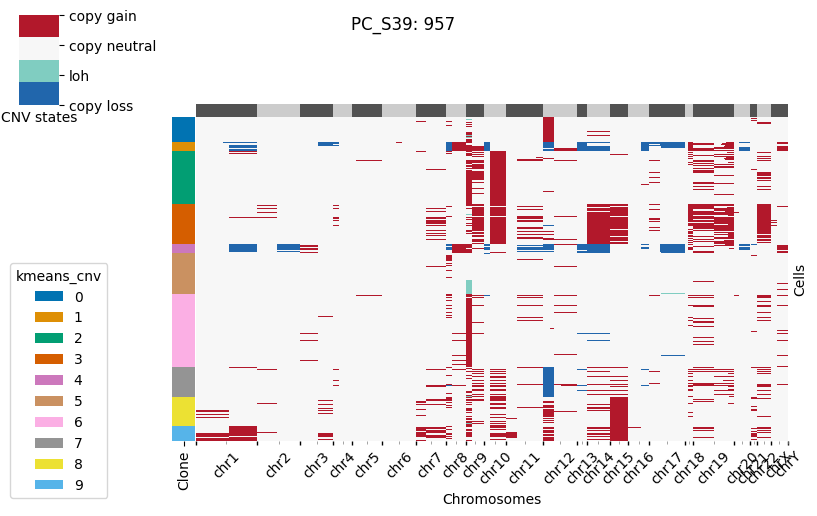

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 12p | Mode Match: 0.98
Cluster 1: CNVs in 8p, 8q, 10p, 12p, 13q, 16q, 18q | Mode Match: 0.87
Cluster 2: CNVs in 9p, 10q | Mode Match: 0.96
Cluster 3: CNVs in 9q, 10q, 14q, 15q, 18q, 22q | Mode Match: 0.90
Cluster 4: CNVs in 1q, 8q, 9p, 12p, 13q, 14q, 17q, Xq | Mode Match: 0.90
Cluster 5: No CNVs or low mode match | Mode Match: 0.99
Cluster 6: CNVs in 9p | Mode Match: 0.98
Cluster 7: CNVs in 12p | Mode Match: 0.93
Cluster 8: CNVs in 15q | Mode Match: 0.94
Cluster 9: CNVs in 1q, 12p, 15q | Mode Match: 0.87


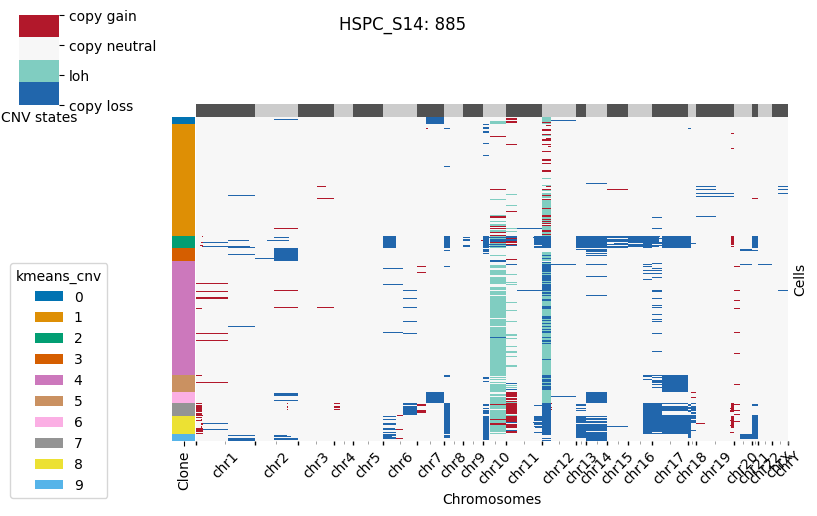

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 7q, 12p | Mode Match: 0.97
Cluster 1: No CNVs or low mode match | Mode Match: 0.98
Cluster 2: CNVs in 6p, 8p, 10p, 10q, 11p, 11q, 12p, 13q, 14q, 16q, 17p, 17q, 18p, 21q | Mode Match: 0.92
Cluster 3: CNVs in 2q, 12p | Mode Match: 0.95
Cluster 4: CNVs in 10q, 12p | Mode Match: 0.98
Cluster 5: CNVs in 10q, 12p, 17q | Mode Match: 0.96
Cluster 6: CNVs in 7q, 12p, 14q | Mode Match: 0.96
Cluster 7: CNVs in 8p, 10q, 11p, 12p, 16q, 17p | Mode Match: 0.93
Cluster 8: CNVs in 8p, 10p, 10q, 11p, 12p, 13q, 16q, 17p, 17q, 18p, 21q | Mode Match: 0.94
Cluster 9: CNVs in 10p, 14q, 20q | Mode Match: 0.94


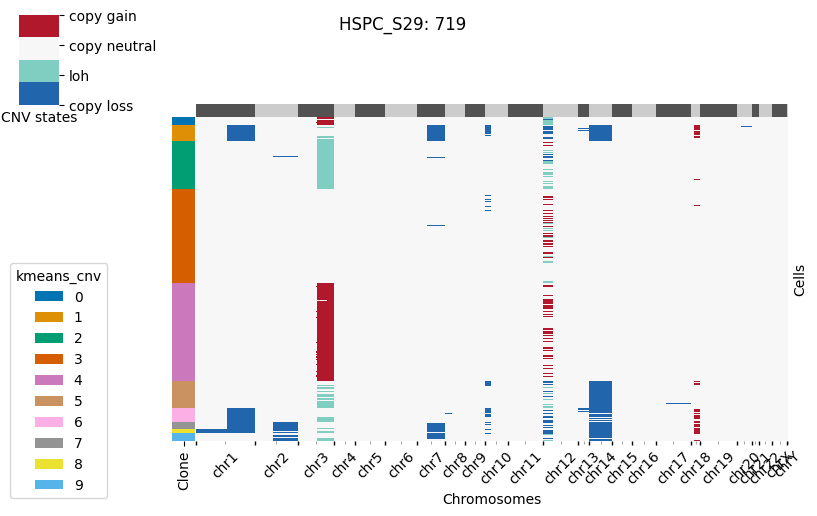

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3q, 12p | Mode Match: 0.99
Cluster 1: CNVs in 1q, 7q, 14q | Mode Match: 0.97
Cluster 2: CNVs in 3q | Mode Match: 0.99
Cluster 3: No CNVs or low mode match | Mode Match: 0.99
Cluster 4: CNVs in 3q | Mode Match: 0.99
Cluster 5: CNVs in 14q | Mode Match: 0.98
Cluster 6: CNVs in 1q, 14q | Mode Match: 0.96
Cluster 7: CNVs in 1q, 2q, 14q | Mode Match: 0.97
Cluster 8: CNVs in 1p, 1q, 12p, 14q, 18q | Mode Match: 0.96
Cluster 9: CNVs in 7q, 14q | Mode Match: 0.95


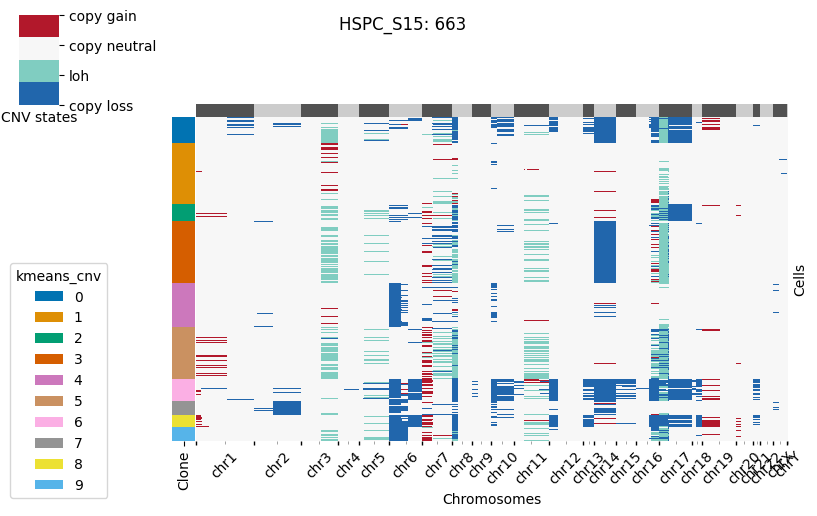

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 8p, 14q, 16q, 17p, 17q | Mode Match: 0.89
Cluster 1: No CNVs or low mode match | Mode Match: 0.97
Cluster 2: CNVs in 8p, 16q, 17p, 17q | Mode Match: 0.91
Cluster 3: CNVs in 8p, 14q, 17p | Mode Match: 0.94
Cluster 4: CNVs in 6p | Mode Match: 0.98
Cluster 5: CNVs in 8p, 17p | Mode Match: 0.91
Cluster 6: CNVs in 6p, 6q, 8p, 10p, 10q, 12p, 14q, 16q, 17p, 17q | Mode Match: 0.88
Cluster 7: CNVs in 2q, 6p | Mode Match: 0.93
Cluster 8: CNVs in 6p, 6q, 8p, 12p, 13q, 16q, 17p, 17q, 18q | Mode Match: 0.91
Cluster 9: CNVs in 6p, 8p, 16q, 17p | Mode Match: 0.91


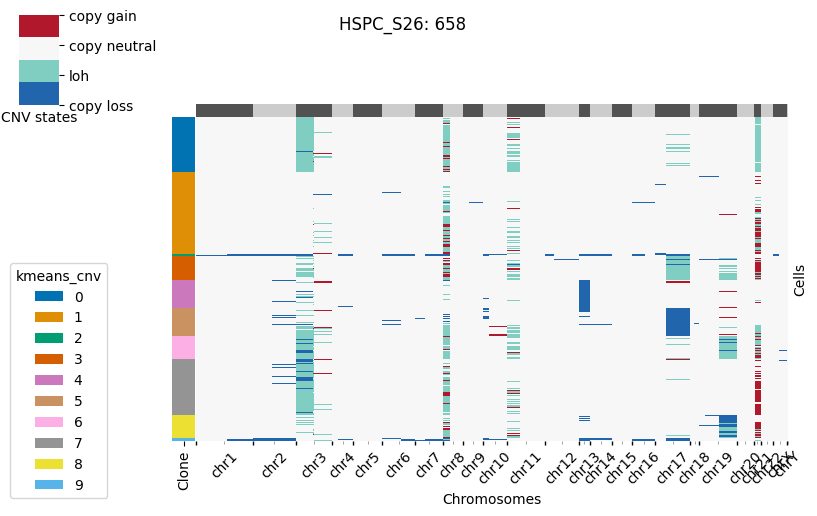

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3p, 8p, 21q | Mode Match: 0.98
Cluster 1: No CNVs or low mode match | Mode Match: 0.98
Cluster 2: CNVs in 2p, 2q, 4q, 6p, 6q, 7q, 8p, 10p, 13q, 14q, 17q | Mode Match: 0.92
Cluster 3: CNVs in 8p, 17q, 21q | Mode Match: 0.95
Cluster 4: CNVs in 13q | Mode Match: 0.98
Cluster 5: CNVs in 17q | Mode Match: 0.94
Cluster 6: CNVs in 3p, 8p, 19q, 21q | Mode Match: 0.97
Cluster 7: CNVs in 3p, 8p | Mode Match: 0.97
Cluster 8: CNVs in 19q | Mode Match: 0.95
Cluster 9: CNVs in 1q, 2p, 2q, 6q, 8p, 10p, 13q, 16p, 16q, 17q | Mode Match: 0.87


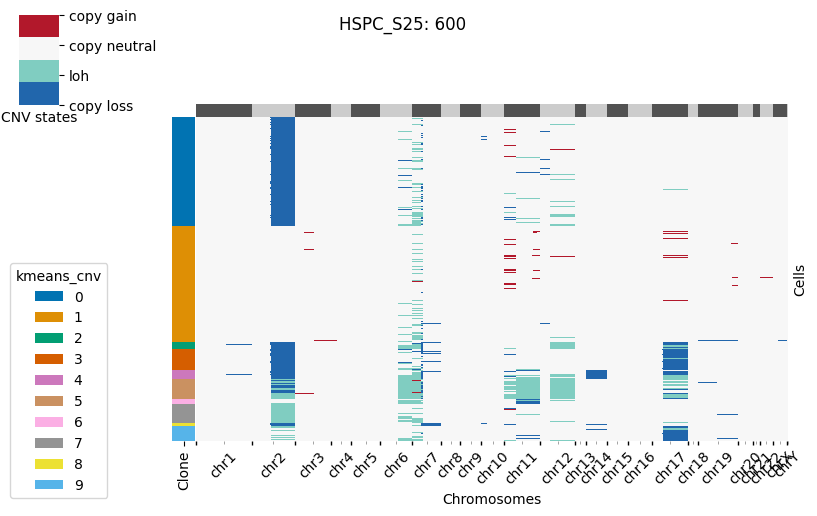

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 2q | Mode Match: 0.99
Cluster 1: No CNVs or low mode match | Mode Match: 0.99
Cluster 2: CNVs in 2q, 7p, 12q, 17q | Mode Match: 0.96
Cluster 3: CNVs in 2q, 17q | Mode Match: 0.98
Cluster 4: CNVs in 2q, 14q | Mode Match: 0.91
Cluster 5: CNVs in 2q, 6q, 7p, 11q, 12q | Mode Match: 0.95
Cluster 6: CNVs in 7p, 11q | Mode Match: 0.96
Cluster 7: CNVs in 2q | Mode Match: 0.98
Cluster 8: CNVs in 2q, 7q | Mode Match: 0.96
Cluster 9: CNVs in 17q | Mode Match: 0.96


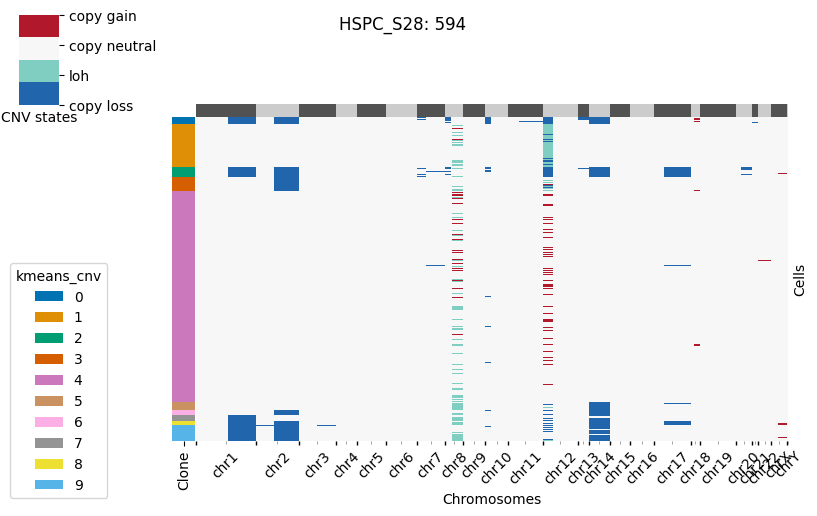

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 1q, 2q, 8p, 10p, 12p, 14q | Mode Match: 0.97
Cluster 1: CNVs in 12p | Mode Match: 0.99
Cluster 2: CNVs in 1q, 2q, 12p, 14q, 17q | Mode Match: 0.97
Cluster 3: CNVs in 2q | Mode Match: 0.98
Cluster 4: No CNVs or low mode match | Mode Match: 0.99
Cluster 5: CNVs in 14q | Mode Match: 0.99
Cluster 6: CNVs in 2q, 14q | Mode Match: 0.98
Cluster 7: CNVs in 1q | Mode Match: 0.97
Cluster 8: CNVs in 1q, 2q, 8q, 14q, 17q | Mode Match: 0.99
Cluster 9: CNVs in 1q, 2q, 14q | Mode Match: 0.97


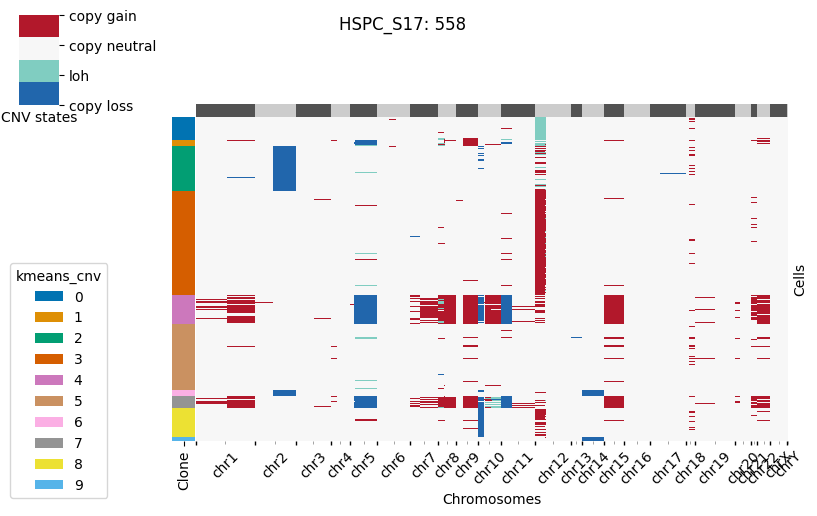

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 12p | Mode Match: 0.99
Cluster 1: CNVs in 5q, 9q, 12p | Mode Match: 0.95
Cluster 2: CNVs in 2q | Mode Match: 0.99
Cluster 3: CNVs in 12p | Mode Match: 0.99
Cluster 4: CNVs in 1q, 5q, 8p, 8q, 9q, 10p, 10q, 11p, 15q, 21q, 22q | Mode Match: 0.93
Cluster 5: No CNVs or low mode match | Mode Match: 0.99
Cluster 6: CNVs in 2q, 14q | Mode Match: 0.99
Cluster 7: CNVs in 1q, 5q, 8p, 8q, 9q, 10p, 11p, 15q, 21q, 22q | Mode Match: 0.92
Cluster 8: CNVs in 10p | Mode Match: 0.98
Cluster 9: CNVs in 14q | Mode Match: 0.99


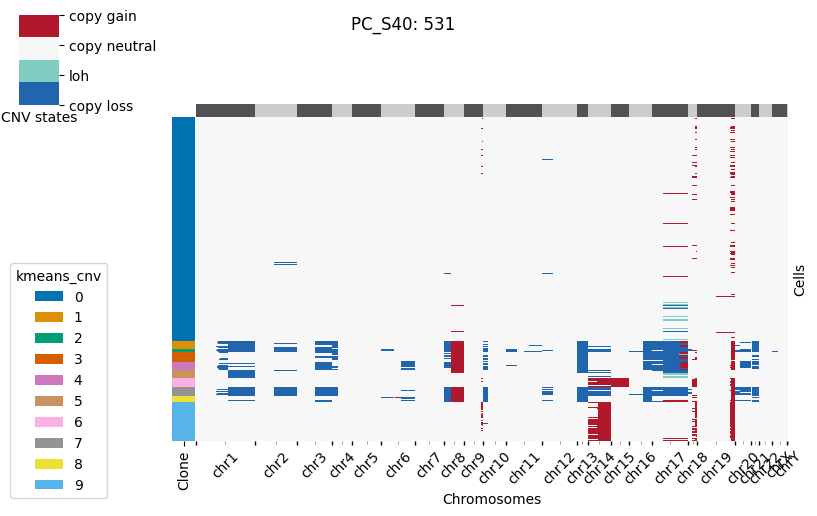

<Figure size 640x480 with 0 Axes>

Cluster 0: No CNVs or low mode match | Mode Match: 0.99
Cluster 1: CNVs in 1q, 3q, 8p, 8q, 13q, 16q, 17p, 17q, 21q | Mode Match: 0.95
Cluster 2: CNVs in 1p, 1q, 2q, 3q, 4p, 8p, 8q, 10p, 13q, 14q, 16q, 17q, 20q, 21q | Mode Match: 0.93
Cluster 3: CNVs in 8q, 13q, 16q, 17p, 17q | Mode Match: 0.96
Cluster 4: CNVs in 3q, 6q, 8p, 8q, 10p, 13q, 16q, 17p, 17q, 20q | Mode Match: 0.96
Cluster 5: CNVs in 1q, 17q | Mode Match: 0.93
Cluster 6: CNVs in 14q, 15q, 18q | Mode Match: 0.99
Cluster 7: CNVs in 1q, 2q, 3q, 4p, 8p, 8q, 10p, 13q, 14q, 16q, 17p, 17q, 20q, 21q | Mode Match: 0.97
Cluster 8: CNVs in 8p, 8q, 10p, 13q, 16q | Mode Match: 0.92
Cluster 9: CNVs in 14q | Mode Match: 0.99


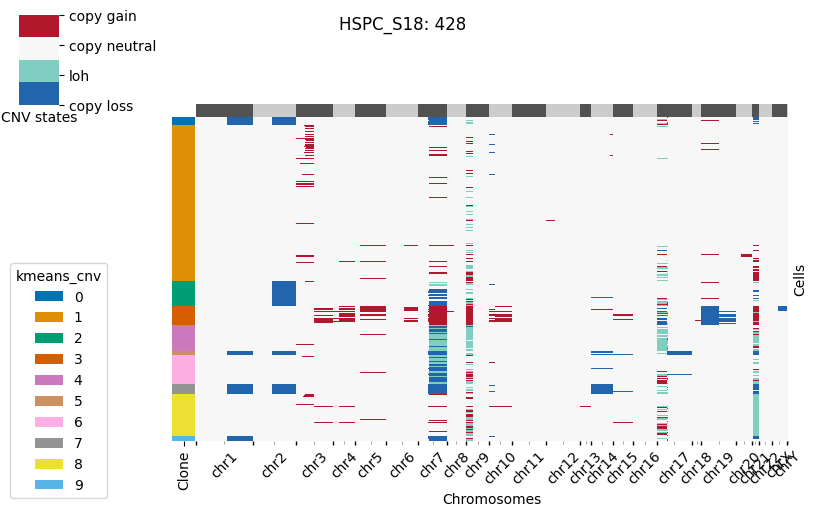

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 1q, 2q, 7q | Mode Match: 0.98
Cluster 1: No CNVs or low mode match | Mode Match: 0.99
Cluster 2: CNVs in 2q | Mode Match: 0.97
Cluster 3: CNVs in 7q, 9p, 19p, 21q | Mode Match: 0.89
Cluster 4: CNVs in 7q, 9p, 17p, 21q | Mode Match: 0.98
Cluster 5: CNVs in 1q, 2q, 7q, 17q, 21q | Mode Match: 0.97
Cluster 6: CNVs in 7q | Mode Match: 0.96
Cluster 7: CNVs in 1q, 2q, 7q, 14q, 21q | Mode Match: 0.98
Cluster 8: CNVs in 21q | Mode Match: 0.98
Cluster 9: CNVs in 1q, 7q | Mode Match: 0.98


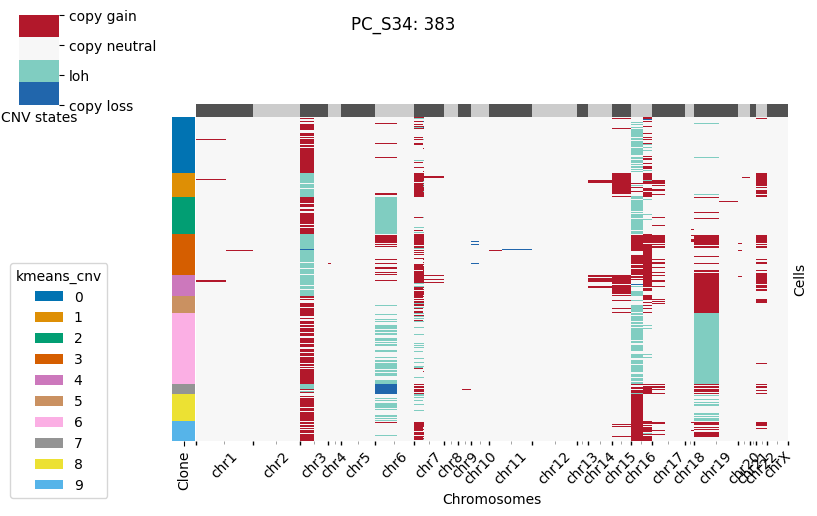

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3p | Mode Match: 0.97
Cluster 1: CNVs in 3p, 7p, 15q, 16q, 22q | Mode Match: 0.96
Cluster 2: CNVs in 3p, 6p, 16p | Mode Match: 0.98
Cluster 3: CNVs in 3p, 16p, 16q | Mode Match: 0.93
Cluster 4: CNVs in 3p, 7p, 15q, 19p | Mode Match: 0.94
Cluster 5: CNVs in 19p | Mode Match: 0.95
Cluster 6: CNVs in 3p, 16p, 19p | Mode Match: 0.97
Cluster 7: CNVs in 3p, 6p, 16q | Mode Match: 0.95
Cluster 8: CNVs in 3p, 16p | Mode Match: 0.95
Cluster 9: CNVs in 16p, 16q | Mode Match: 0.95


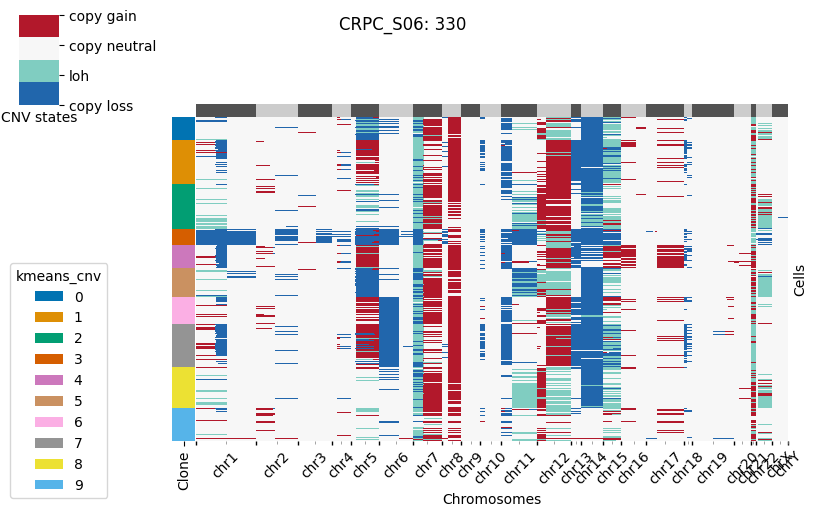

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 5q, 7p, 7q, 8q, 12q, 14q, 21q | Mode Match: 0.87
Cluster 1: CNVs in 5q, 7p, 8q, 11p, 12q, 13q, 14q, 15q, 21q | Mode Match: 0.91
Cluster 2: CNVs in 7p, 7q, 12p, 12q, 14q, 21q | Mode Match: 0.86
Cluster 3: CNVs in 1p, 1q, 5q, 6p, 7p, 11p, 11q, 12q, 13q, 14q, 15q, 21q | Mode Match: 0.87
Cluster 4: CNVs in 1p, 5q, 7p, 7q, 8q, 11p, 12q, 13q, 15q, 16p, 17q, 21q | Mode Match: 0.90
Cluster 5: CNVs in 5q, 7p, 7q, 11q, 12p, 12q, 14q, 21q, 22q | Mode Match: 0.90
Cluster 6: CNVs in 6p, 7p, 7q, 8q, 11p, 12q, 14q, 21q | Mode Match: 0.89
Cluster 7: CNVs in 5q, 6p, 7p, 8q, 11p, 12q, 13q, 14q, 15q, 18p, 21q | Mode Match: 0.91
Cluster 8: CNVs in 7p, 7q, 8q, 11q, 12p, 14q, 21q | Mode Match: 0.90
Cluster 9: CNVs in 21q | Mode Match: 0.85


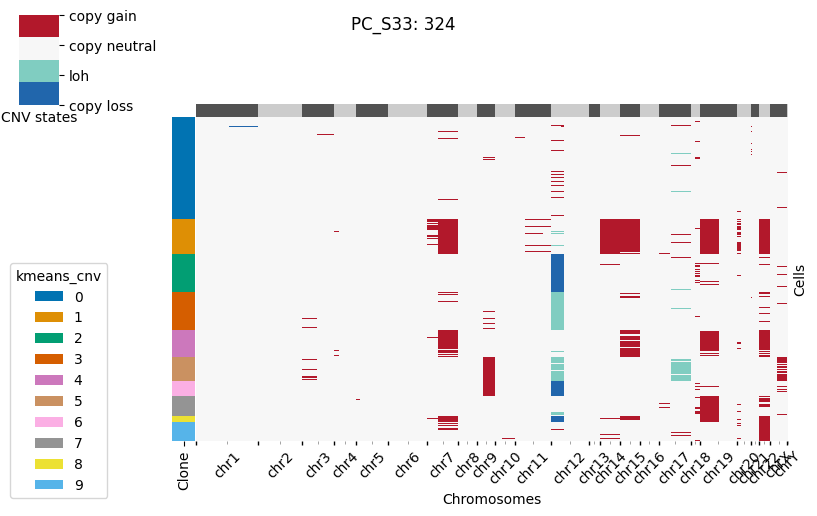

<Figure size 640x480 with 0 Axes>

Cluster 0: No CNVs or low mode match | Mode Match: 0.99
Cluster 1: CNVs in 7q, 14q, 15q, 19p, 22q | Mode Match: 0.98
Cluster 2: CNVs in 12p | Mode Match: 0.99
Cluster 3: CNVs in 12p | Mode Match: 0.99
Cluster 4: CNVs in 7q, 15q, 19p, 22q | Mode Match: 0.98
Cluster 5: CNVs in 9q, 12p, 17q, Xq | Mode Match: 0.98
Cluster 6: CNVs in 9q, 12p | Mode Match: 0.99
Cluster 7: CNVs in 19p | Mode Match: 0.98
Cluster 8: CNVs in 7q, 12p, 19p, 22q | Mode Match: 0.98
Cluster 9: CNVs in 22q | Mode Match: 0.98


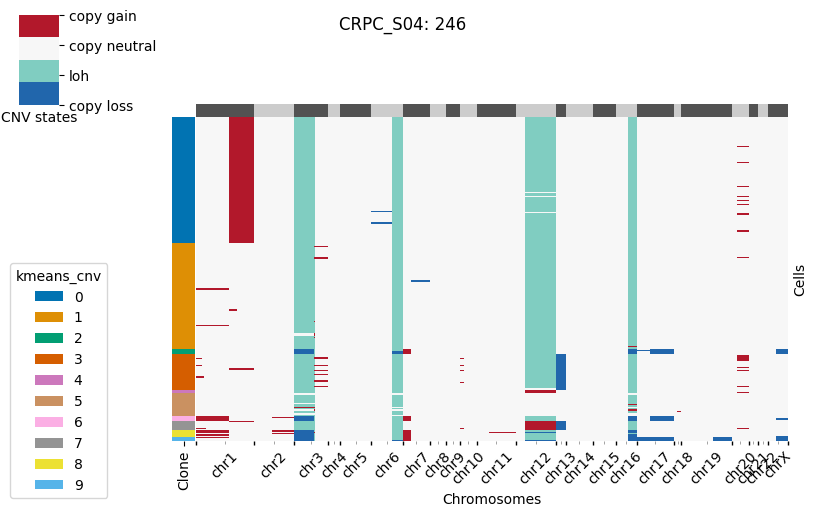

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 1q, 3p, 6q, 12q, 16q | Mode Match: 1.00
Cluster 1: CNVs in 3p, 6q, 12q, 16q | Mode Match: 1.00
Cluster 2: CNVs in 3p, 6q, 7p, 12q, 16q, 17q, Xq | Mode Match: 0.99
Cluster 3: CNVs in 3p, 6q, 12q, 13q, 16q | Mode Match: 0.98
Cluster 4: CNVs in 3p, 6q, 12q, 16q | Mode Match: 0.99
Cluster 5: CNVs in 3p, 6q, 16q | Mode Match: 0.98
Cluster 6: CNVs in 1p, 3p, 6q, 7p, 12q, 16q, 17q | Mode Match: 0.99
Cluster 7: CNVs in 3p, 6q, 12q, 13q, 16q | Mode Match: 0.99
Cluster 8: CNVs in 3p, 6q, 7p, 12q, 16q | Mode Match: 0.94
Cluster 9: CNVs in 3p, 6q, 7p, 12q, 16q, 17p, 17q, 19q, Xq | Mode Match: 0.96


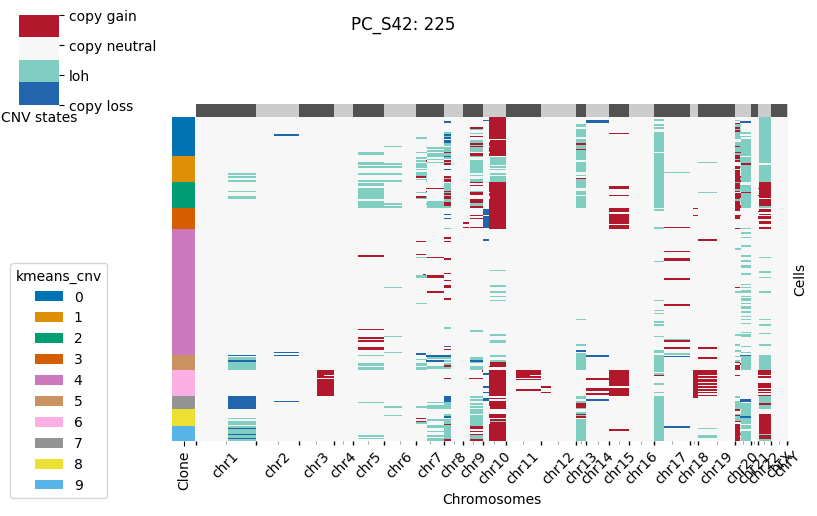

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 10q, 20p, 22q | Mode Match: 0.94
Cluster 1: CNVs in 13q, 17p, 20p, 20q, 22q | Mode Match: 0.92
Cluster 2: CNVs in 5q, 8p, 10q, 13q, 17p, 20p, 20q, 22q | Mode Match: 0.93
Cluster 3: CNVs in 10p, 10q, 15q | Mode Match: 0.96
Cluster 4: No CNVs or low mode match | Mode Match: 0.97
Cluster 5: CNVs in 1q, 13q, 17p, 20q, 22q | Mode Match: 0.88
Cluster 6: CNVs in 3q, 10q, 15q, 18q | Mode Match: 0.94
Cluster 7: CNVs in 1q, 8p, 10q, 13q, 17p, 20p, 22q | Mode Match: 0.92
Cluster 8: CNVs in 9q, 17p, 20q | Mode Match: 0.93
Cluster 9: CNVs in 1q, 8p, 9q, 10q, 13q, 17p, 20p, 20q, 22q | Mode Match: 0.93


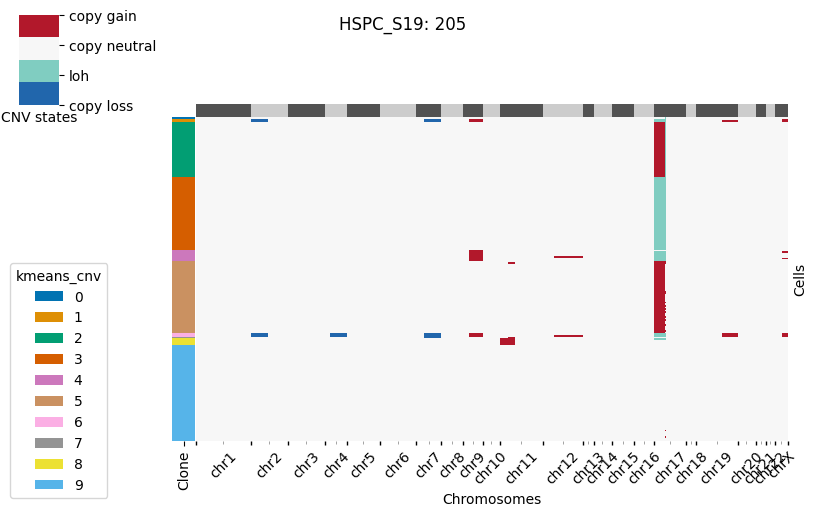

<Figure size 640x480 with 0 Axes>

Cluster 0: No CNVs or low mode match | Mode Match: 1.00
Cluster 1: CNVs in 2p, 7q, 9q, 17p, Xq | Mode Match: 0.99
Cluster 2: CNVs in 17p | Mode Match: 1.00
Cluster 3: CNVs in 17p | Mode Match: 1.00
Cluster 4: CNVs in 9q, 17p | Mode Match: 0.99
Cluster 5: CNVs in 17p | Mode Match: 1.00
Cluster 6: CNVs in 2p, 4q, 7q, 9q, 17p, 19q, Xq | Mode Match: 0.98
Cluster 7: CNVs in 7q | Mode Match: 1.00
Cluster 8: CNVs in 11p | Mode Match: 1.00
Cluster 9: No CNVs or low mode match | Mode Match: 1.00


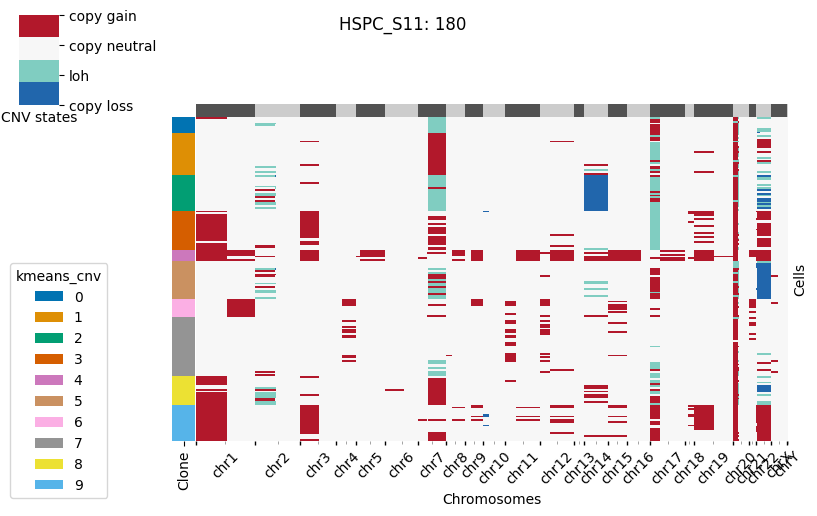

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 7q, 17p, 20p | Mode Match: 0.97
Cluster 1: CNVs in 7q, 17p, 20p | Mode Match: 0.96
Cluster 2: CNVs in 7q, 14q, 17p, 20p | Mode Match: 0.96
Cluster 3: CNVs in 1p, 3p, 17p, 20p, 22q | Mode Match: 0.95
Cluster 4: CNVs in 1p, 3p, 5q, 9q, 11q, 12q, 15q, 16p, 19p, 20p, 22q | Mode Match: 0.91
Cluster 5: CNVs in 7q, 17p, 20p, 22q | Mode Match: 0.95
Cluster 6: CNVs in 1q, 20p | Mode Match: 0.93
Cluster 7: CNVs in 20p | Mode Match: 0.96
Cluster 8: CNVs in 1p, 7q, 17p, 20p | Mode Match: 0.92
Cluster 9: CNVs in 1p, 3p, 17p, 20p, 22q | Mode Match: 0.93


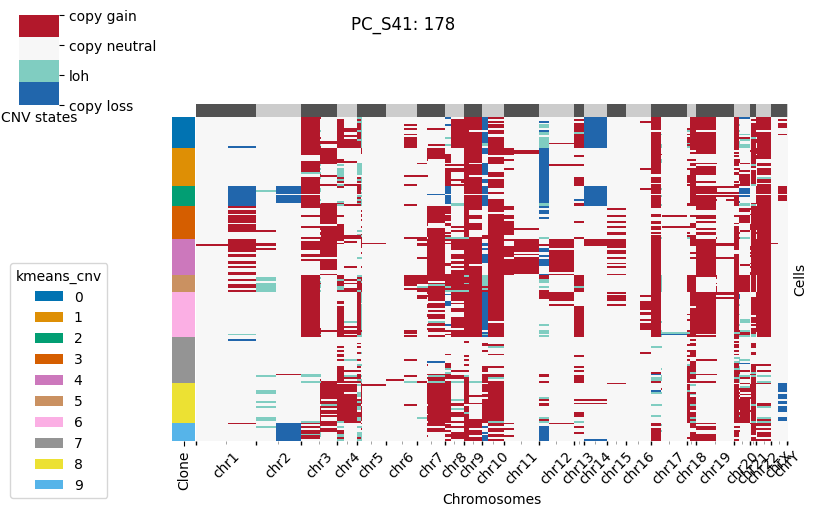

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 3p, 4p, 5p, 8q, 9p, 9q, 10p, 13q, 14q, 17p, 18q, 19p, 20p, 21q, 22q | Mode Match: 0.92
Cluster 1: CNVs in 3p, 8p, 9p, 9q, 12p, 17p, 21q, 22q | Mode Match: 0.87
Cluster 2: CNVs in 1q, 3p, 5p, 8p, 9p, 9q, 10p, 12p, 14q, 17p, 18q, 19p, 22q | Mode Match: 0.90
Cluster 3: CNVs in 3q, 7q, 9p, 10q, 21q, 22q | Mode Match: 0.86
Cluster 4: CNVs in 3q, 7q, 9p, 9q, 10q, 11p, 11q, 12q, 17p, 19p, 20p, 21q, 22q | Mode Match: 0.88
Cluster 5: CNVs in 2p, 3p, 4p, 5p, 6q, 7p, 7q, 8p, 8q, 9p, 9q, 10p, 10q, 13q, 17p, 18p, 18q, 20p, 20q, 21q, 22q | Mode Match: 0.91
Cluster 6: CNVs in 3p, 4p, 5p, 9p, 9q, 10p, 10q, 17p, 18q, 19p, 20p, 21q, 22q | Mode Match: 0.91
Cluster 7: CNVs in 20p | Mode Match: 0.90
Cluster 8: CNVs in 3q, 4p, 4q, 7q, 8p, 9p, 10p, 10q, 18p, 20p, 20q, 21q | Mode Match: 0.91
Cluster 9: CNVs in 2q, 9p, 9q, 12p, 17p, 18q, 21q | Mode Match: 0.87


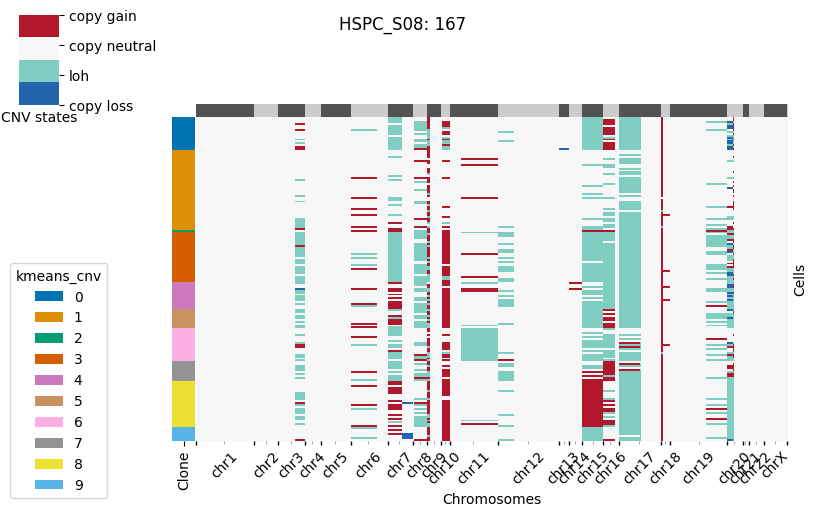

<Figure size 640x480 with 0 Axes>

Cluster 0: CNVs in 7p, 9p, 10q, 15q, 16p, 17p, 18p, 20p | Mode Match: 0.95
Cluster 1: CNVs in 9p, 18p | Mode Match: 0.94
Cluster 2: CNVs in 6p, 7p, 8q, 9p, 10q, 15q, 16p, 17p, 18p, 19q, 20p | Mode Match: 1.00
Cluster 3: CNVs in 3q, 7p, 8q, 9p, 10q, 15q, 16p, 17p, 18p, 20p | Mode Match: 0.94
Cluster 4: CNVs in 9p, 10q, 16p, 17p, 18p, 20p | Mode Match: 0.90
Cluster 5: CNVs in 8q, 9p, 10q, 15q, 17p, 18p, 20p | Mode Match: 0.93
Cluster 6: CNVs in 9p, 11q, 16p, 18p | Mode Match: 0.91
Cluster 7: CNVs in 7p, 9p, 16p, 17p, 18p | Mode Match: 0.91
Cluster 8: CNVs in 9p, 10q, 15q, 17p, 18p, 20p | Mode Match: 0.93
Cluster 9: CNVs in 9p, 10q, 15q, 17p, 18p, 20p | Mode Match: 0.95


In [22]:
use_layer = "prob1_merge"
cnv_clustering_key = 'kmeans_cnv'

# Set number of clusters
n_clusters = 10  # Adjust as needed

adata_obs_dict = {}
#sample = samples_list[3]
for sample in samples_sorted_by_n:

        adata = adata_cnv_profiles_dict[sample].copy()

        # Perform PCA on the data matrix
        pca = PCA(n_components=15)
        #X_pca = pca.fit_transform(adata.X)
        X_pca = pca.fit_transform(assign_cna_states(adata.layers[use_layer]))

        # Apply KMeans clustering on the top 15 PCs
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(X_pca)

        adata.obs[cnv_clustering_key] = cluster_labels
        n_cells = adata.shape[0]

        xclone.pl.Combine_CNV_visualization(adata, Xlayer = use_layer,
                cell_anno_key = cnv_clustering_key,
                title=f'{sample}: {n_cells}',
                figsize=(8,5)
        )
        plt.tight_layout()
        plt.savefig(f'./plots/cnv_heatmaps/{sample}_cnvs.pdf')
        plt.show()

        adata_obs_dict[sample] = analyze_cancer_clusters(adata)

In [23]:
concat_obs_data = pd.concat(adata_obs_dict).reset_index(level=0).drop(columns=('level_0'))
concat_obs_data.to_csv('/scratch/svc_td_grpc/users/kiviaho/lyu_2024_scs/preprocessed_h5ad/epithelial_cancer_cell_annotation_20250818.csv')
concat_obs_data['CNV_status'].value_counts()

CNV_status
CNVpos cancer    22031
Benign            8768
Name: count, dtype: int64

In [25]:
# Test whether there's more cancer cells pre- or post-treatment
grp1 = 'PC'
grp2 = 'HSPC'
df = concat_obs_data[concat_obs_data['type'].isin([grp1,grp2])]
crosstab_df = pd.crosstab(df['type'],df['CNV_status']).loc[[grp1,grp2],['CNVpos cancer','Benign']]
print(crosstab_df)
fisher_exact(crosstab_df)

CNV_status  CNVpos cancer  Benign
type                             
PC                   7764    1195
HSPC                10005    7573


SignificanceResult(statistic=np.float64(4.917773079987203), pvalue=np.float64(0.0))

In [81]:
#concat_obs_data = pd.concat(adata_obs_dict).reset_index(level=0).drop(columns=('level_0'))
#concat_obs_data.to_csv('./preprocessed_h5ad/epithelial_cancer_cell_annotation_20250618.csv')
#concat_obs_data['CNV_status'].value_counts()

CNV_status
CNVpos cancer    12214
Benign            6450
Name: count, dtype: int64